# Directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Thesis/'

/content/drive/MyDrive/Thesis


In [3]:
!pip install torchmetrics[image] torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 59.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [4]:
import torch

def get_device():
    """
    Returns the available device ('cuda', 'mps', or 'cpu').
    """
    if torch.cuda.is_available():
        return 'cuda'
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

device = get_device()
print('Device in use:', device)

Device in use: cuda


# MNIST

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Load the test dataset from MNIST
mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=64, shuffle=False)

print(f"\nNumber of imagesof the test set: {len(mnist_test_dataset)}")
print(f"\nNumber of batches of the test set: {len(mnist_test_loader)}")


Number of imagesof the test set: 10000

Number of batches of the test set: 157


## FID

In [ ]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for 2D images
        num_classes= None,
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

### 1. VP Deterministic

In [ ]:
model.load_state_dict(torch.load("trained/VP_unconditioned.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import math

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm + s) / (1 + s)) * (torch.pi / 2))
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

def score_fn(model, x, t_norm):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm)
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, schedule = 'linear', T = 1, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)


            # Get the score (using the noise-predicting network)
            score = score_fn(model, xt, t_batch)

            # Euler–Maruyama update:
            xt = xt + (f - (g**2) * score / 2) * dt

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

total_samples = len(mnist_test_dataset)
batch_size = 64
num_batches = total_samples // batch_size

generated_images = []

# Generate all batches
for batch_idx in range(num_batches):
    print(f"Generating batch {batch_idx + 1}/{num_batches}")
    samples = sample(
        model=model,
        n_samples=batch_size,
        reverse_steps=500,
        T=1,
        gif=False
    )
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    # Normalize images to [0, 1]
    final_step_images = (final_step_images - final_step_images.min()) / (final_step_images.max() - final_step_images.min())
    generated_images.append(final_step_images)

# Stack all generated images
generated_images = torch.cat(generated_images, dim=0)
print(f"Generated images shape: {generated_images.shape}")

Generating batch 1/156


100%|██████████| 500/500 [00:20<00:00, 24.32it/s]
<ipython-input-21-40b7e5a4b64f>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


Generating batch 2/156


100%|██████████| 500/500 [00:20<00:00, 24.84it/s]


Generating batch 3/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 4/156


100%|██████████| 500/500 [00:20<00:00, 24.56it/s]


Generating batch 5/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 6/156


100%|██████████| 500/500 [00:20<00:00, 24.50it/s]


Generating batch 7/156


100%|██████████| 500/500 [00:23<00:00, 21.41it/s]


Generating batch 8/156


100%|██████████| 500/500 [00:22<00:00, 22.20it/s]


Generating batch 9/156


100%|██████████| 500/500 [00:20<00:00, 24.07it/s]


Generating batch 10/156


100%|██████████| 500/500 [00:20<00:00, 24.61it/s]


Generating batch 11/156


100%|██████████| 500/500 [00:20<00:00, 24.07it/s]


Generating batch 12/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 13/156


100%|██████████| 500/500 [00:22<00:00, 21.91it/s]


Generating batch 14/156


100%|██████████| 500/500 [00:25<00:00, 19.77it/s]


Generating batch 15/156


100%|██████████| 500/500 [00:20<00:00, 24.53it/s]


Generating batch 16/156


100%|██████████| 500/500 [00:20<00:00, 24.55it/s]


Generating batch 17/156


100%|██████████| 500/500 [00:20<00:00, 23.93it/s]


Generating batch 18/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 19/156


100%|██████████| 500/500 [00:24<00:00, 20.62it/s]


Generating batch 20/156


100%|██████████| 500/500 [00:20<00:00, 24.39it/s]


Generating batch 21/156


100%|██████████| 500/500 [00:20<00:00, 24.17it/s]


Generating batch 22/156


100%|██████████| 500/500 [00:20<00:00, 24.18it/s]


Generating batch 23/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 24/156


100%|██████████| 500/500 [00:21<00:00, 23.20it/s]


Generating batch 25/156


100%|██████████| 500/500 [00:19<00:00, 25.12it/s]


Generating batch 26/156


100%|██████████| 500/500 [00:20<00:00, 24.52it/s]


Generating batch 27/156


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Generating batch 28/156


100%|██████████| 500/500 [00:20<00:00, 24.80it/s]


Generating batch 29/156


100%|██████████| 500/500 [00:20<00:00, 24.04it/s]


Generating batch 30/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 31/156


100%|██████████| 500/500 [00:20<00:00, 24.09it/s]


Generating batch 32/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 33/156


100%|██████████| 500/500 [00:20<00:00, 24.29it/s]


Generating batch 34/156


100%|██████████| 500/500 [00:20<00:00, 24.86it/s]


Generating batch 35/156


100%|██████████| 500/500 [00:20<00:00, 24.49it/s]


Generating batch 36/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 37/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 38/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 39/156


100%|██████████| 500/500 [00:24<00:00, 20.56it/s]


Generating batch 40/156


100%|██████████| 500/500 [00:25<00:00, 19.61it/s]


Generating batch 41/156


100%|██████████| 500/500 [00:27<00:00, 18.49it/s]


Generating batch 42/156


100%|██████████| 500/500 [00:25<00:00, 19.71it/s]


Generating batch 43/156


100%|██████████| 500/500 [00:22<00:00, 22.37it/s]


Generating batch 44/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 45/156


100%|██████████| 500/500 [00:21<00:00, 23.73it/s]


Generating batch 46/156


100%|██████████| 500/500 [00:20<00:00, 24.29it/s]


Generating batch 47/156


100%|██████████| 500/500 [00:22<00:00, 22.42it/s]


Generating batch 48/156


100%|██████████| 500/500 [00:21<00:00, 23.43it/s]


Generating batch 49/156


100%|██████████| 500/500 [00:22<00:00, 22.32it/s]


Generating batch 50/156


100%|██████████| 500/500 [00:20<00:00, 24.31it/s]


Generating batch 51/156


100%|██████████| 500/500 [00:27<00:00, 18.42it/s]


Generating batch 52/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 53/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 54/156


100%|██████████| 500/500 [00:20<00:00, 24.33it/s]


Generating batch 55/156


100%|██████████| 500/500 [00:21<00:00, 23.57it/s]


Generating batch 56/156


100%|██████████| 500/500 [00:21<00:00, 23.61it/s]


Generating batch 57/156


100%|██████████| 500/500 [00:22<00:00, 22.13it/s]


Generating batch 58/156


100%|██████████| 500/500 [00:20<00:00, 24.40it/s]


Generating batch 59/156


100%|██████████| 500/500 [00:20<00:00, 24.30it/s]


Generating batch 60/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 61/156


100%|██████████| 500/500 [00:21<00:00, 23.74it/s]


Generating batch 62/156


100%|██████████| 500/500 [00:20<00:00, 24.89it/s]


Generating batch 63/156


100%|██████████| 500/500 [00:20<00:00, 24.32it/s]


Generating batch 64/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 65/156


100%|██████████| 500/500 [00:20<00:00, 24.41it/s]


Generating batch 66/156


100%|██████████| 500/500 [00:20<00:00, 24.56it/s]


Generating batch 67/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 68/156


100%|██████████| 500/500 [00:20<00:00, 24.48it/s]


Generating batch 69/156


100%|██████████| 500/500 [00:20<00:00, 24.94it/s]


Generating batch 70/156


100%|██████████| 500/500 [00:20<00:00, 24.42it/s]


Generating batch 71/156


100%|██████████| 500/500 [00:19<00:00, 25.16it/s]


Generating batch 72/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 73/156


100%|██████████| 500/500 [00:20<00:00, 24.94it/s]


Generating batch 74/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 75/156


100%|██████████| 500/500 [00:20<00:00, 24.83it/s]


Generating batch 76/156


100%|██████████| 500/500 [00:20<00:00, 24.47it/s]


Generating batch 77/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 78/156


100%|██████████| 500/500 [00:20<00:00, 24.47it/s]


Generating batch 79/156


100%|██████████| 500/500 [00:20<00:00, 24.19it/s]


Generating batch 80/156


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Generating batch 81/156


100%|██████████| 500/500 [00:20<00:00, 24.51it/s]


Generating batch 82/156


100%|██████████| 500/500 [00:19<00:00, 25.01it/s]


Generating batch 83/156


100%|██████████| 500/500 [00:20<00:00, 24.45it/s]


Generating batch 84/156


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Generating batch 85/156


100%|██████████| 500/500 [00:20<00:00, 24.36it/s]


Generating batch 86/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 87/156


100%|██████████| 500/500 [00:20<00:00, 24.46it/s]


Generating batch 88/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 89/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 90/156


100%|██████████| 500/500 [00:20<00:00, 24.50it/s]


Generating batch 91/156


100%|██████████| 500/500 [00:19<00:00, 25.05it/s]


Generating batch 92/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 93/156


100%|██████████| 500/500 [00:19<00:00, 25.11it/s]


Generating batch 94/156


100%|██████████| 500/500 [00:20<00:00, 24.53it/s]


Generating batch 95/156


100%|██████████| 500/500 [00:20<00:00, 24.98it/s]


Generating batch 96/156


100%|██████████| 500/500 [00:20<00:00, 24.45it/s]


Generating batch 97/156


100%|██████████| 500/500 [00:20<00:00, 24.82it/s]


Generating batch 98/156


100%|██████████| 500/500 [00:20<00:00, 24.48it/s]


Generating batch 99/156


100%|██████████| 500/500 [00:20<00:00, 24.63it/s]


Generating batch 100/156


100%|██████████| 500/500 [00:20<00:00, 24.67it/s]


Generating batch 101/156


100%|██████████| 500/500 [00:20<00:00, 24.42it/s]


Generating batch 102/156


100%|██████████| 500/500 [00:19<00:00, 25.01it/s]


Generating batch 103/156


100%|██████████| 500/500 [00:20<00:00, 24.65it/s]


Generating batch 104/156


100%|██████████| 500/500 [00:19<00:00, 25.02it/s]


Generating batch 105/156


100%|██████████| 500/500 [00:20<00:00, 24.37it/s]


Generating batch 106/156


100%|██████████| 500/500 [00:19<00:00, 25.06it/s]


Generating batch 107/156


100%|██████████| 500/500 [00:20<00:00, 24.42it/s]


Generating batch 108/156


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Generating batch 109/156


100%|██████████| 500/500 [00:20<00:00, 24.52it/s]


Generating batch 110/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 111/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 112/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 113/156


100%|██████████| 500/500 [00:19<00:00, 25.06it/s]


Generating batch 114/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 115/156


100%|██████████| 500/500 [00:20<00:00, 24.97it/s]


Generating batch 116/156


100%|██████████| 500/500 [00:20<00:00, 24.53it/s]


Generating batch 117/156


100%|██████████| 500/500 [00:20<00:00, 24.88it/s]


Generating batch 118/156


100%|██████████| 500/500 [00:20<00:00, 24.46it/s]


Generating batch 119/156


100%|██████████| 500/500 [00:19<00:00, 25.00it/s]


Generating batch 120/156


100%|██████████| 500/500 [00:20<00:00, 24.41it/s]


Generating batch 121/156


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Generating batch 122/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 123/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 124/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 125/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 126/156


100%|██████████| 500/500 [00:19<00:00, 25.01it/s]


Generating batch 127/156


100%|██████████| 500/500 [00:20<00:00, 24.39it/s]


Generating batch 128/156


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Generating batch 129/156


100%|██████████| 500/500 [00:20<00:00, 24.39it/s]


Generating batch 130/156


100%|██████████| 500/500 [00:20<00:00, 24.84it/s]


Generating batch 131/156


100%|██████████| 500/500 [00:20<00:00, 24.37it/s]


Generating batch 132/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 133/156


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Generating batch 134/156


100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


Generating batch 135/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 136/156


100%|██████████| 500/500 [00:20<00:00, 24.47it/s]


Generating batch 137/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 138/156


100%|██████████| 500/500 [00:20<00:00, 24.38it/s]


Generating batch 139/156


100%|██████████| 500/500 [00:20<00:00, 24.83it/s]


Generating batch 140/156


100%|██████████| 500/500 [00:20<00:00, 24.26it/s]


Generating batch 141/156


100%|██████████| 500/500 [00:20<00:00, 24.88it/s]


Generating batch 142/156


100%|██████████| 500/500 [00:20<00:00, 24.35it/s]


Generating batch 143/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 144/156


100%|██████████| 500/500 [00:20<00:00, 24.80it/s]


Generating batch 145/156


100%|██████████| 500/500 [00:20<00:00, 24.63it/s]


Generating batch 146/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 147/156


100%|██████████| 500/500 [00:20<00:00, 24.45it/s]


Generating batch 148/156


100%|██████████| 500/500 [00:19<00:00, 25.09it/s]


Generating batch 149/156


100%|██████████| 500/500 [00:20<00:00, 24.41it/s]


Generating batch 150/156


100%|██████████| 500/500 [00:20<00:00, 24.90it/s]


Generating batch 151/156


100%|██████████| 500/500 [00:20<00:00, 24.39it/s]


Generating batch 152/156


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Generating batch 153/156


100%|██████████| 500/500 [00:20<00:00, 24.44it/s]


Generating batch 154/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 155/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 156/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]

Generated images shape: torch.Size([9984, 1, 32, 32])


In [ ]:
import torchmetrics as tm

fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)


for batch in mnist_test_loader:
    images, _ = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
        # print(f"Fake:{images.min()}, {images.max()}")
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=True)

# Resize generated images
generated_images = F.interpolate(generated_images, size=(299, 299), mode='bilinear', align_corners=False)

# Make fake_loader
fake_dataset = TensorDataset(generated_images)
fake_loader = DataLoader(fake_dataset, batch_size=64, shuffle=False)

for batch in fake_loader:
    (images,) = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
        # print(f"Fake:{images.min()}, {images.max()}")
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=False)

fid_score = fid.compute()
print(f"FID Score: {fid_score.item()}")

Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0

### 2. VP Stochastic

In [ ]:
model.load_state_dict(torch.load("trained/VP_unconditioned.pth"))

In [ ]:
from tqdm import tqdm
import math
import torch

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm + s) / (1 + s)) * (torch.pi / 2))
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

def score_fn(model, x, t_norm):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm)
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, schedule = 'linear', T = 1, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)


            # Get the score (using the noise-predicting network)
            score = score_fn(model, xt, t_batch)

            # Euler–Maruyama update:
            z = torch.randn_like(xt)
            xt = xt + (f - (g**2) * score) * dt + g * torch.sqrt(-dt) * z

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

total_samples = len(mnist_test_dataset)
batch_size = 64
num_batches = total_samples // batch_size

generated_images = []

# Generate all batches
for batch_idx in range(num_batches):
    print(f"Generating batch {batch_idx + 1}/{num_batches}")
    samples = sample(
        model=model,
        n_samples=batch_size,
        reverse_steps=500,
        T=1,
        gif=False
    )
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    # Normalize images to [0, 1]
    final_step_images = (final_step_images - final_step_images.min()) / (final_step_images.max() - final_step_images.min())
    generated_images.append(final_step_images)

# Stack all generated images
generated_images = torch.cat(generated_images, dim=0)
print(f"Generated images shape: {generated_images.shape}")

In [ ]:
import torchmetrics as tm

fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)


for batch in mnist_test_loader:
    images, _ = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=True)

# Resize generated images
generated_images = F.interpolate(generated_images, size=(299, 299), mode='bilinear', align_corners=False)

# Make fake_loader
fake_dataset = TensorDataset(generated_images)
fake_loader = DataLoader(fake_dataset, batch_size=64, shuffle=False)

for batch in fake_loader:
    (images,) = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=False)

fid_score = fid.compute()
print(f"FID Score: {fid_score.item()}")

### 3. Flow Matching

In [ ]:
model.load_state_dict(torch.load("trained/flow_matching_unconditioned.pth"))

In [ ]:
from tqdm import tqdm

def sample(model, n_samples, steps, T = 1, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_norm_batch = t_batch / T

            xt = xt + (T / steps) * model(xt, t_norm_batch)

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

total_samples = len(mnist_test_dataset)
batch_size = 64
num_batches = total_samples // batch_size

generated_images = []

# Generate all batches
for batch_idx in range(num_batches):
    print(f"Generating batch {batch_idx + 1}/{num_batches}")
    samples = sample(
        model=model,
        n_samples=batch_size,
        steps=500,
        T=1,
        gif=False
    )
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    # Normalize images to [0, 1]
    final_step_images = (final_step_images - final_step_images.min()) / (final_step_images.max() - final_step_images.min())
    generated_images.append(final_step_images)

# Stack all generated images
generated_images = torch.cat(generated_images, dim=0)
print(f"Generated images shape: {generated_images.shape}")

In [ ]:
import torchmetrics as tm

fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)


for batch in mnist_test_loader:
    images, _ = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=True)

# Resize generated images
generated_images = F.interpolate(generated_images, size=(299, 299), mode='bilinear', align_corners=False)

# Make fake_loader
fake_dataset = TensorDataset(generated_images)
fake_loader = DataLoader(fake_dataset, batch_size=64, shuffle=False)

for batch in fake_loader:
    (images,) = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=False)

fid_score = fid.compute()
print(f"FID Score: {fid_score.item()}")

### 4. Bridge Matching

In [ ]:
model.load_state_dict(torch.load("trained/bridge_matching_unconditioned.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import numpy as np

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def sample(model, n_samples, steps, T = 1, sigma=0.5, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_comp = match_last_dims(t_batch, xt.shape)
            t_norm_batch = t_batch / T
            noise = torch.randn_like(xt)

            # Predict the clean x_t
            v = (model(xt, t_norm_batch) - xt) / (1 - t_comp + 1e-5)

            xt = xt + (T / steps) * v + np.sqrt(T / steps) * sigma * noise

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

total_samples = len(mnist_test_dataset)
batch_size = 64
num_batches = total_samples // batch_size

generated_images = []

# Generate all batches
for batch_idx in range(num_batches):
    print(f"Generating batch {batch_idx + 1}/{num_batches}")
    samples = sample(
        model=model,
        n_samples=batch_size,
        steps=500,
        T=1,
        sigma=0.5,
        gif=False
    )
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    # Normalize images to [0, 1]
    final_step_images = (final_step_images - final_step_images.min()) / (final_step_images.max() - final_step_images.min())
    generated_images.append(final_step_images)

# Stack all generated images
generated_images = torch.cat(generated_images, dim=0)
print(f"Generated images shape: {generated_images.shape}")

Generating batch 1/156


100%|██████████| 500/500 [00:20<00:00, 24.61it/s]
<ipython-input-21-312cb77d2bf1>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


Generating batch 2/156


100%|██████████| 500/500 [00:20<00:00, 24.32it/s]


Generating batch 3/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 4/156


100%|██████████| 500/500 [00:19<00:00, 25.18it/s]


Generating batch 5/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 6/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 7/156


100%|██████████| 500/500 [00:20<00:00, 24.64it/s]


Generating batch 8/156


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Generating batch 9/156


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Generating batch 10/156


100%|██████████| 500/500 [00:20<00:00, 24.84it/s]


Generating batch 11/156


100%|██████████| 500/500 [00:20<00:00, 24.86it/s]


Generating batch 12/156


100%|██████████| 500/500 [00:20<00:00, 24.64it/s]


Generating batch 13/156


100%|██████████| 500/500 [00:19<00:00, 25.07it/s]


Generating batch 14/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 15/156


100%|██████████| 500/500 [00:19<00:00, 25.03it/s]


Generating batch 16/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 17/156


100%|██████████| 500/500 [00:19<00:00, 25.08it/s]


Generating batch 18/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 19/156


100%|██████████| 500/500 [00:19<00:00, 25.04it/s]


Generating batch 20/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 21/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 22/156


100%|██████████| 500/500 [00:20<00:00, 24.76it/s]


Generating batch 23/156


100%|██████████| 500/500 [00:20<00:00, 24.89it/s]


Generating batch 24/156


100%|██████████| 500/500 [00:20<00:00, 24.85it/s]


Generating batch 25/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 26/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 27/156


100%|██████████| 500/500 [00:20<00:00, 24.48it/s]


Generating batch 28/156


100%|██████████| 500/500 [00:20<00:00, 24.76it/s]


Generating batch 29/156


100%|██████████| 500/500 [00:20<00:00, 24.40it/s]


Generating batch 30/156


100%|██████████| 500/500 [00:19<00:00, 25.03it/s]


Generating batch 31/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 32/156


100%|██████████| 500/500 [00:19<00:00, 25.04it/s]


Generating batch 33/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 34/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 35/156


100%|██████████| 500/500 [00:20<00:00, 24.75it/s]


Generating batch 36/156


100%|██████████| 500/500 [00:20<00:00, 24.78it/s]


Generating batch 37/156


100%|██████████| 500/500 [00:20<00:00, 24.80it/s]


Generating batch 38/156


100%|██████████| 500/500 [00:20<00:00, 24.46it/s]


Generating batch 39/156


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Generating batch 40/156


100%|██████████| 500/500 [00:20<00:00, 24.54it/s]


Generating batch 41/156


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Generating batch 42/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 43/156


100%|██████████| 500/500 [00:19<00:00, 25.00it/s]


Generating batch 44/156


100%|██████████| 500/500 [00:20<00:00, 24.52it/s]


Generating batch 45/156


100%|██████████| 500/500 [00:19<00:00, 25.01it/s]


Generating batch 46/156


100%|██████████| 500/500 [00:20<00:00, 24.55it/s]


Generating batch 47/156


100%|██████████| 500/500 [00:20<00:00, 24.82it/s]


Generating batch 48/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 49/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 50/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 51/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 52/156


100%|██████████| 500/500 [00:19<00:00, 25.09it/s]


Generating batch 53/156


100%|██████████| 500/500 [00:20<00:00, 24.65it/s]


Generating batch 54/156


100%|██████████| 500/500 [00:19<00:00, 25.03it/s]


Generating batch 55/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 56/156


100%|██████████| 500/500 [00:19<00:00, 25.02it/s]


Generating batch 57/156


100%|██████████| 500/500 [00:20<00:00, 24.61it/s]


Generating batch 58/156


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Generating batch 59/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 60/156


100%|██████████| 500/500 [00:20<00:00, 24.84it/s]


Generating batch 61/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 62/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 63/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 64/156


100%|██████████| 500/500 [00:20<00:00, 24.63it/s]


Generating batch 65/156


100%|██████████| 500/500 [00:19<00:00, 25.00it/s]


Generating batch 66/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 67/156


100%|██████████| 500/500 [00:19<00:00, 25.04it/s]


Generating batch 68/156


100%|██████████| 500/500 [00:20<00:00, 24.67it/s]


Generating batch 69/156


100%|██████████| 500/500 [00:19<00:00, 25.07it/s]


Generating batch 70/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 71/156


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Generating batch 72/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 73/156


100%|██████████| 500/500 [00:20<00:00, 24.89it/s]


Generating batch 74/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 75/156


100%|██████████| 500/500 [00:20<00:00, 24.78it/s]


Generating batch 76/156


100%|██████████| 500/500 [00:20<00:00, 24.89it/s]


Generating batch 77/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 78/156


100%|██████████| 500/500 [00:19<00:00, 25.00it/s]


Generating batch 79/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 80/156


100%|██████████| 500/500 [00:20<00:00, 25.00it/s]


Generating batch 81/156


100%|██████████| 500/500 [00:20<00:00, 24.61it/s]


Generating batch 82/156


100%|██████████| 500/500 [00:20<00:00, 24.97it/s]


Generating batch 83/156


100%|██████████| 500/500 [00:20<00:00, 24.61it/s]


Generating batch 84/156


100%|██████████| 500/500 [00:20<00:00, 25.00it/s]


Generating batch 85/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 86/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 87/156


100%|██████████| 500/500 [00:20<00:00, 24.85it/s]


Generating batch 88/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 89/156


100%|██████████| 500/500 [00:20<00:00, 24.89it/s]


Generating batch 90/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 91/156


100%|██████████| 500/500 [00:19<00:00, 25.04it/s]


Generating batch 92/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 93/156


100%|██████████| 500/500 [00:19<00:00, 25.02it/s]


Generating batch 94/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 95/156


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Generating batch 96/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 97/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 98/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 99/156


100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


Generating batch 100/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 101/156


100%|██████████| 500/500 [00:20<00:00, 24.65it/s]


Generating batch 102/156


100%|██████████| 500/500 [00:20<00:00, 24.87it/s]


Generating batch 103/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 104/156


100%|██████████| 500/500 [00:19<00:00, 25.05it/s]


Generating batch 105/156


100%|██████████| 500/500 [00:20<00:00, 24.56it/s]


Generating batch 106/156


100%|██████████| 500/500 [00:20<00:00, 24.98it/s]


Generating batch 107/156


100%|██████████| 500/500 [00:20<00:00, 24.55it/s]


Generating batch 108/156


100%|██████████| 500/500 [00:20<00:00, 24.94it/s]


Generating batch 109/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 110/156


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Generating batch 111/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 112/156


100%|██████████| 500/500 [00:20<00:00, 24.86it/s]


Generating batch 113/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 114/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 115/156


100%|██████████| 500/500 [00:20<00:00, 24.85it/s]


Generating batch 116/156


100%|██████████| 500/500 [00:20<00:00, 24.55it/s]


Generating batch 117/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 118/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 119/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 120/156


100%|██████████| 500/500 [00:20<00:00, 24.54it/s]


Generating batch 121/156


100%|██████████| 500/500 [00:20<00:00, 24.88it/s]


Generating batch 122/156


100%|██████████| 500/500 [00:20<00:00, 24.54it/s]


Generating batch 123/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 124/156


100%|██████████| 500/500 [00:20<00:00, 24.54it/s]


Generating batch 125/156


100%|██████████| 500/500 [00:20<00:00, 24.45it/s]


Generating batch 126/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 127/156


100%|██████████| 500/500 [00:20<00:00, 24.65it/s]


Generating batch 128/156


100%|██████████| 500/500 [00:20<00:00, 24.92it/s]


Generating batch 129/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 130/156


100%|██████████| 500/500 [00:20<00:00, 24.94it/s]


Generating batch 131/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 132/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 133/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 134/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 135/156


100%|██████████| 500/500 [00:20<00:00, 24.87it/s]


Generating batch 136/156


100%|██████████| 500/500 [00:20<00:00, 24.64it/s]


Generating batch 137/156


100%|██████████| 500/500 [00:19<00:00, 25.12it/s]


Generating batch 138/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 139/156


100%|██████████| 500/500 [00:19<00:00, 25.04it/s]


Generating batch 140/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 141/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 142/156


100%|██████████| 500/500 [00:20<00:00, 24.68it/s]


Generating batch 143/156


100%|██████████| 500/500 [00:20<00:00, 24.78it/s]


Generating batch 144/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 145/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 146/156


100%|██████████| 500/500 [00:19<00:00, 25.01it/s]


Generating batch 147/156


100%|██████████| 500/500 [00:20<00:00, 24.63it/s]


Generating batch 148/156


100%|██████████| 500/500 [00:19<00:00, 25.05it/s]


Generating batch 149/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 150/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 151/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 152/156


100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


Generating batch 153/156


100%|██████████| 500/500 [00:20<00:00, 24.97it/s]


Generating batch 154/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 155/156


100%|██████████| 500/500 [00:19<00:00, 25.07it/s]


Generating batch 156/156


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Generated images shape: torch.Size([9984, 1, 32, 32])


In [ ]:
import torchmetrics as tm

fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)


for batch in mnist_test_loader:
    images, _ = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=True)

# Resize generated images
generated_images = F.interpolate(generated_images, size=(299, 299), mode='bilinear', align_corners=False)

# Make fake_loader
fake_dataset = TensorDataset(generated_images)
fake_loader = DataLoader(fake_dataset, batch_size=64, shuffle=False)

for batch in fake_loader:
    (images,) = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=False)

fid_score = fid.compute()
print(f"FID Score: {fid_score.item()}")

## cFID

In [ ]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes= 10,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

### 1. VP Deterministic

In [ ]:
model.load_state_dict(torch.load("trained/VP_conditioned.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import math

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm + s) / (1 + s)) * (torch.pi / 2))
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

def score_fn(model, x, t_norm, y):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm, y)
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, class_label, schedule = 'linear', T = 1, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)

            # Compute conditional score
            cond_class_label = torch.full((shape[0],), class_label, device=device)
            score_cond = score_fn(model, xt, t_batch, cond_class_label)

            # Euler–Maruyama update:
            xt = xt + (f - (g**2) * score_cond / 2) * dt

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchmetrics as tm
from collections import defaultdict

# Prepare per-class real image buffers
real_images_by_class = defaultdict(list)
for images, labels in mnist_test_loader:
    for i in range(10):
        mask = labels == i
        class_images = images[mask]
        if class_images.shape[1] == 1:
            class_images = class_images.repeat(1, 3, 1, 1)
        real_images_by_class[i].append(class_images)

for k in real_images_by_class:
    real_images_by_class[k] = torch.cat(real_images_by_class[k], dim=0)

In [ ]:
# Generate conditional images per class
generated_images_by_class = defaultdict(list)
n_samples_per_class = len(mnist_test_dataset) // 10
batch_size = 64

for class_label in range(10):
    num_batches = n_samples_per_class // batch_size
    for batch_idx in range(num_batches):
        print(f"Generating class {class_label} batch {batch_idx + 1}/{num_batches}")
        samples = sample(
            model=model,
            n_samples=batch_size,
            reverse_steps=500,
            class_label=class_label,
            T=1,
            gif=False
        )
        images = torch.stack([torch.tensor(s).cpu() for s in samples])
        images = (images - images.min()) / (images.max() - images.min())  # Normalize to [0,1]
        generated_images_by_class[class_label].append(images)

    generated_images_by_class[class_label] = torch.cat(generated_images_by_class[class_label], dim=0)

In [ ]:
# Compute cFID per class
fid_scores = []
for class_label in range(10):
    fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)

    # Real images
    real_images = real_images_by_class[class_label]
    real_images = (real_images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(real_images.to(device), real=True)

    # Generated images
    fake_images = generated_images_by_class[class_label]
    fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)
    fake_images = fake_images.repeat(1, 3, 1, 1) if fake_images.shape[1] == 1 else fake_images
    fake_images = (fake_images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(fake_images.to(device), real=False)

    score = fid.compute().item()
    fid_scores.append(score)
    print(f"FID for class {class_label}: {score:.4f}")

# Average FID across all classes
cfid_score = sum(fid_scores) / len(fid_scores)
print(f"\nConditional FID (cFID): {cfid_score:.4f}")

### 2. VP - Stochastic

In [ ]:
model.load_state_dict(torch.load("trained/VP_conditioned.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import math

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm + s) / (1 + s)) * (torch.pi / 2))
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

def score_fn(model, x, t_norm, y):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm, y)
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, class_label, schedule = 'linear', T = 1, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)

            # Compute conditional score
            cond_class_label = torch.full((shape[0],), class_label, device=device)
            score_cond = score_fn(model, xt, t_batch, cond_class_label)

            # Euler–Maruyama update:
            xt = xt + (f - (g**2) * score_cond) * dt + g * torch.sqrt(-dt) * z

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchmetrics as tm
from collections import defaultdict

# Prepare per-class real image buffers
real_images_by_class = defaultdict(list)
for images, labels in mnist_test_loader:
    for i in range(10):
        mask = labels == i
        class_images = images[mask]
        if class_images.shape[1] == 1:
            class_images = class_images.repeat(1, 3, 1, 1)
        real_images_by_class[i].append(class_images)

for k in real_images_by_class:
    real_images_by_class[k] = torch.cat(real_images_by_class[k], dim=0)

In [ ]:
# Generate conditional images per class
generated_images_by_class = defaultdict(list)
n_samples_per_class = len(mnist_test_dataset) // 10
batch_size = 64

for class_label in range(10):
    num_batches = n_samples_per_class // batch_size
    for batch_idx in range(num_batches):
        print(f"Generating class {class_label} batch {batch_idx + 1}/{num_batches}")
        samples = sample(
            model=model,
            n_samples=batch_size,
            reverse_steps=500,
            class_label=class_label,
            T=1,
            gif=False
        )
        images = torch.stack([torch.tensor(s).cpu() for s in samples])
        images = (images - images.min()) / (images.max() - images.min())  # Normalize to [0,1]
        generated_images_by_class[class_label].append(images)

    generated_images_by_class[class_label] = torch.cat(generated_images_by_class[class_label], dim=0)

In [ ]:
# Compute cFID per class
fid_scores = []
for class_label in range(10):
    fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)

    # Real images
    real_images = real_images_by_class[class_label]
    real_images = (real_images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(real_images.to(device), real=True)

    # Generated images
    fake_images = generated_images_by_class[class_label]
    fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)
    fake_images = fake_images.repeat(1, 3, 1, 1) if fake_images.shape[1] == 1 else fake_images
    fake_images = (fake_images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(fake_images.to(device), real=False)

    score = fid.compute().item()
    fid_scores.append(score)
    print(f"FID for class {class_label}: {score:.4f}")

# Average FID across all classes
cfid_score = sum(fid_scores) / len(fid_scores)
print(f"\nConditional FID (cFID): {cfid_score:.4f}")

### 3. Flow Matching

In [ ]:
model.load_state_dict(torch.load("trained/flow_matching_conditioned.pth"))

In [ ]:
from tqdm import tqdm

def sample(model, n_samples, steps, class_label, T = 1, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_norm_batch = t_batch / T

            # Compute conditional score
            cond_class_label = torch.full((shape[0],), class_label, device=device)

            # Euler–Maruyama update:
            xt = xt + (T / steps) * model(xt, t_norm_batch, cond_class_label)

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchmetrics as tm
from collections import defaultdict

# Prepare per-class real image buffers
real_images_by_class = defaultdict(list)
for images, labels in mnist_test_loader:
    for i in range(10):
        mask = labels == i
        class_images = images[mask]
        if class_images.shape[1] == 1:
            class_images = class_images.repeat(1, 3, 1, 1)
        real_images_by_class[i].append(class_images)

for k in real_images_by_class:
    real_images_by_class[k] = torch.cat(real_images_by_class[k], dim=0)

In [ ]:
# Generate conditional images per class
generated_images_by_class = defaultdict(list)
n_samples_per_class = len(mnist_test_dataset) // 10
batch_size = 64

for class_label in range(10):
    num_batches = n_samples_per_class // batch_size
    for batch_idx in range(num_batches):
        print(f"Generating class {class_label} batch {batch_idx + 1}/{num_batches}")
        samples = sample(
            model=model,
            n_samples=batch_size,
            steps=500,
            class_label=class_label,
            T=1,
            gif=False
        )
        images = torch.stack([torch.tensor(s).cpu() for s in samples])
        images = (images - images.min()) / (images.max() - images.min())  # Normalize to [0,1]
        generated_images_by_class[class_label].append(images)

    generated_images_by_class[class_label] = torch.cat(generated_images_by_class[class_label], dim=0)

In [ ]:
# Compute cFID per class
fid_scores = []
for class_label in range(10):
    fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)

    # Real images
    real_images = real_images_by_class[class_label]
    real_images = (real_images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(real_images.to(device), real=True)

    # Generated images
    fake_images = generated_images_by_class[class_label]
    fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)
    fake_images = fake_images.repeat(1, 3, 1, 1) if fake_images.shape[1] == 1 else fake_images
    fake_images = (fake_images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(fake_images.to(device), real=False)

    score = fid.compute().item()
    fid_scores.append(score)
    print(f"FID for class {class_label}: {score:.4f}")

# Average FID across all classes
cfid_score = sum(fid_scores) / len(fid_scores)
print(f"\nConditional FID (cFID): {cfid_score:.4f}")

### 4. Bridge Matching

In [ ]:
model.load_state_dict(torch.load("trained/bridge_matching_conditioned.pth"))

In [ ]:
from tqdm import tqdm

def sample(model, n_samples, steps, class_label, T = 1, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_norm_batch = t_batch / T

            # Compute conditional score
            cond_class_label = torch.full((shape[0],), class_label, device=device)

            # Predict the clean x_t
            v = (model(xt, t_norm_batch, cond_class_label) - xt) / (1 - t_comp + 1e-5)

            xt = xt + (T / steps) * v + np.sqrt(T / steps) * sigma * noise

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchmetrics as tm
from collections import defaultdict

# Prepare per-class real image buffers
real_images_by_class = defaultdict(list)
for images, labels in mnist_test_loader:
    for i in range(10):
        mask = labels == i
        class_images = images[mask]
        if class_images.shape[1] == 1:
            class_images = class_images.repeat(1, 3, 1, 1)
        real_images_by_class[i].append(class_images)

for k in real_images_by_class:
    real_images_by_class[k] = torch.cat(real_images_by_class[k], dim=0)

In [ ]:
# Generate conditional images per class
generated_images_by_class = defaultdict(list)
n_samples_per_class = len(mnist_test_dataset) // 10
batch_size = 64

for class_label in range(10):
    num_batches = n_samples_per_class // batch_size
    for batch_idx in range(num_batches):
        print(f"Generating class {class_label} batch {batch_idx + 1}/{num_batches}")
        samples = sample(
            model=model,
            n_samples=batch_size,
            steps=500,
            class_label=class_label,
            T=1,
            gif=False
        )
        images = torch.stack([torch.tensor(s).cpu() for s in samples])
        images = (images - images.min()) / (images.max() - images.min())  # Normalize to [0,1]
        generated_images_by_class[class_label].append(images)

    generated_images_by_class[class_label] = torch.cat(generated_images_by_class[class_label], dim=0)

In [ ]:
# Compute cFID per class
fid_scores = []
for class_label in range(10):
    fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)

    # Real images
    real_images = real_images_by_class[class_label]
    real_images = (real_images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(real_images.to(device), real=True)

    # Generated images
    fake_images = generated_images_by_class[class_label]
    fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)
    fake_images = fake_images.repeat(1, 3, 1, 1) if fake_images.shape[1] == 1 else fake_images
    fake_images = (fake_images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(fake_images.to(device), real=False)

    score = fid.compute().item()
    fid_scores.append(score)
    print(f"FID for class {class_label}: {score:.4f}")

# Average FID across all classes
cfid_score = sum(fid_scores) / len(fid_scores)
print(f"\nConditional FID (cFID): {cfid_score:.4f}")

## Classification

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)      # Global context
        y = self.fc(y).view(b, c, 1, 1)      # Channel weights
        return x * y.expand_as(x)            # Reweight input

class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   # 32x32
        self.attn1 = SEBlock(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 16x16 after pool
        self.attn2 = SEBlock(64)

        self.pool = nn.MaxPool2d(2, 2)                # Halves spatial dims
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.attn1(self.conv1(x))))  # -> [32, 16x16]
        x = self.pool(F.relu(self.attn2(self.conv2(x))))  # -> [64, 8x8]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = classifier().to(device)

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Simple training loop
for epoch in range(20):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} done.")

Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.
Epoch 11 done.
Epoch 12 done.
Epoch 13 done.
Epoch 14 done.
Epoch 15 done.
Epoch 16 done.
Epoch 17 done.
Epoch 18 done.
Epoch 19 done.
Epoch 20 done.


In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

test_dataset = MNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
from sklearn.metrics import f1_score
import torch

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

In [ ]:
from sklearn.metrics import classification_report

print("F1 Scores:")
print(classification_report(all_labels, all_preds, digits=4))

F1 Scores:
              precision    recall  f1-score   support

           0     0.9909    1.0000    0.9954       980
           1     0.9956    0.9982    0.9969      1135
           2     0.9913    0.9913    0.9913      1032
           3     0.9921    0.9901    0.9911      1010
           4     0.9949    0.9847    0.9898       982
           5     0.9899    0.9865    0.9882       892
           6     0.9896    0.9906    0.9901       958
           7     0.9893    0.9854    0.9873      1028
           8     0.9867    0.9918    0.9892       974
           9     0.9832    0.9841    0.9837      1009

    accuracy                         0.9904     10000
   macro avg     0.9903    0.9903    0.9903     10000
weighted avg     0.9904    0.9904    0.9904     10000



In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/mnist_classifier.pth")

## Distribution of classes

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)      # Global context
        y = self.fc(y).view(b, c, 1, 1)      # Channel weights
        return x * y.expand_as(x)            # Reweight input

class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   # 32x32
        self.attn1 = SEBlock(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 16x16 after pool
        self.attn2 = SEBlock(64)

        self.pool = nn.MaxPool2d(2, 2)                # Halves spatial dims
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.attn1(self.conv1(x))))  # -> [32, 16x16]
        x = self.pool(F.relu(self.attn2(self.conv2(x))))  # -> [64, 8x8]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = classifier().to(device)
model.load_state_dict(torch.load("trained/mnist_classifier.pth"))

<All keys matched successfully>

In [ ]:
from utils.unet import UNetModel

channels = 1
out_channels = 1

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

unet = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes=None,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

unet = unet.to(device)

### VP

In [ ]:
unet.load_state_dict(torch.load("trained/mnist_VP_unconditioned.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import math

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm + s) / (1 + s)) * (torch.pi / 2))
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

def score_fn(model, x, t_norm):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm)
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, schedule = 'linear', T = 1, gif = False):
    shape = (n_samples, 1, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)


            # Get the score (using the noise-predicting network)
            score = score_fn(model, xt, t_batch)

            # Euler–Maruyama update:
            xt = xt + (f - (g**2) * score / 2) * dt

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Generate fake images
total_samples = len(mnist_test_dataset)
batch_size = 64
num_batches = total_samples // batch_size

generated_images = []

for batch_idx in range(num_batches):
    print(f"Generating batch {batch_idx + 1}/{num_batches}")
    samples = sample(
        model=unet,
        n_samples=batch_size,
        reverse_steps=500,
        T=1,
        gif=False
    )
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    final_step_images = (final_step_images - final_step_images.min()) / (final_step_images.max() - final_step_images.min())  # [0, 1]
    generated_images.append(final_step_images)

generated_images = torch.cat(generated_images, dim=0)  # Shape: [N, 1, 32, 32]
print(f"Generated images shape: {generated_images.shape}")

# Classify using pretrained CNN model
model.eval()
with torch.no_grad():
    inputs = generated_images.to(device)
    outputs = model(inputs)
    predicted_labels = outputs.argmax(dim=1).cpu()

print(f"Predicted labels shape: {predicted_labels.shape}")


Generating batch 1/156


100%|██████████| 500/500 [00:20<00:00, 24.11it/s]
<ipython-input-12-427c964db1d8>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


Generating batch 2/156


100%|██████████| 500/500 [00:24<00:00, 20.28it/s]


Generating batch 3/156


100%|██████████| 500/500 [00:27<00:00, 18.40it/s]


Generating batch 4/156


100%|██████████| 500/500 [00:23<00:00, 21.55it/s]


Generating batch 5/156


100%|██████████| 500/500 [00:25<00:00, 19.55it/s]


Generating batch 6/156


100%|██████████| 500/500 [00:23<00:00, 20.87it/s]


Generating batch 7/156


100%|██████████| 500/500 [00:20<00:00, 23.87it/s]


Generating batch 8/156


100%|██████████| 500/500 [00:22<00:00, 22.14it/s]


Generating batch 9/156


100%|██████████| 500/500 [00:21<00:00, 23.30it/s]


Generating batch 10/156


100%|██████████| 500/500 [00:29<00:00, 17.10it/s]


Generating batch 11/156


100%|██████████| 500/500 [00:20<00:00, 24.97it/s]


Generating batch 12/156


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Generating batch 13/156


100%|██████████| 500/500 [00:19<00:00, 25.25it/s]


Generating batch 14/156


100%|██████████| 500/500 [00:20<00:00, 24.80it/s]


Generating batch 15/156


100%|██████████| 500/500 [00:20<00:00, 24.89it/s]


Generating batch 16/156


100%|██████████| 500/500 [00:20<00:00, 24.80it/s]


Generating batch 17/156


100%|██████████| 500/500 [00:20<00:00, 24.76it/s]


Generating batch 18/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 19/156


100%|██████████| 500/500 [00:19<00:00, 25.14it/s]


Generating batch 20/156


100%|██████████| 500/500 [00:20<00:00, 24.50it/s]


Generating batch 21/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 22/156


100%|██████████| 500/500 [00:19<00:00, 25.02it/s]


Generating batch 23/156


100%|██████████| 500/500 [00:20<00:00, 24.83it/s]


Generating batch 24/156


100%|██████████| 500/500 [00:19<00:00, 25.22it/s]


Generating batch 25/156


100%|██████████| 500/500 [00:20<00:00, 24.78it/s]


Generating batch 26/156


100%|██████████| 500/500 [00:19<00:00, 25.20it/s]


Generating batch 27/156


100%|██████████| 500/500 [00:20<00:00, 24.38it/s]


Generating batch 28/156


100%|██████████| 500/500 [00:19<00:00, 25.27it/s]


Generating batch 29/156


100%|██████████| 500/500 [00:20<00:00, 24.83it/s]


Generating batch 30/156


100%|██████████| 500/500 [00:19<00:00, 25.17it/s]


Generating batch 31/156


100%|██████████| 500/500 [00:20<00:00, 25.00it/s]


Generating batch 32/156


100%|██████████| 500/500 [00:19<00:00, 25.05it/s]


Generating batch 33/156


100%|██████████| 500/500 [00:19<00:00, 25.07it/s]


Generating batch 34/156


100%|██████████| 500/500 [00:20<00:00, 24.82it/s]


Generating batch 35/156


100%|██████████| 500/500 [00:19<00:00, 25.32it/s]


Generating batch 36/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 37/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 38/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 39/156


100%|██████████| 500/500 [00:19<00:00, 25.27it/s]


Generating batch 40/156


100%|██████████| 500/500 [00:20<00:00, 24.65it/s]


Generating batch 41/156


100%|██████████| 500/500 [00:19<00:00, 25.12it/s]


Generating batch 42/156


100%|██████████| 500/500 [00:20<00:00, 24.68it/s]


Generating batch 43/156


100%|██████████| 500/500 [00:19<00:00, 25.03it/s]


Generating batch 44/156


100%|██████████| 500/500 [00:19<00:00, 25.03it/s]


Generating batch 45/156


100%|██████████| 500/500 [00:20<00:00, 24.85it/s]


Generating batch 46/156


100%|██████████| 500/500 [00:19<00:00, 25.21it/s]


Generating batch 47/156


100%|██████████| 500/500 [00:20<00:00, 24.63it/s]


Generating batch 48/156


100%|██████████| 500/500 [00:20<00:00, 24.89it/s]


Generating batch 49/156


100%|██████████| 500/500 [00:20<00:00, 24.76it/s]


Generating batch 50/156


100%|██████████| 500/500 [00:19<00:00, 25.27it/s]


Generating batch 51/156


100%|██████████| 500/500 [00:20<00:00, 24.82it/s]


Generating batch 52/156


100%|██████████| 500/500 [00:19<00:00, 25.21it/s]


Generating batch 53/156


100%|██████████| 500/500 [00:20<00:00, 24.90it/s]


Generating batch 54/156


100%|██████████| 500/500 [00:20<00:00, 25.00it/s]


Generating batch 55/156


100%|██████████| 500/500 [00:19<00:00, 25.04it/s]


Generating batch 56/156


100%|██████████| 500/500 [00:20<00:00, 24.88it/s]


Generating batch 57/156


100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


Generating batch 58/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 59/156


100%|██████████| 500/500 [00:19<00:00, 25.34it/s]


Generating batch 60/156


100%|██████████| 500/500 [00:20<00:00, 24.83it/s]


Generating batch 61/156


100%|██████████| 500/500 [00:19<00:00, 25.33it/s]


Generating batch 62/156


100%|██████████| 500/500 [00:20<00:00, 24.78it/s]


Generating batch 63/156


100%|██████████| 500/500 [00:19<00:00, 25.31it/s]


Generating batch 64/156


100%|██████████| 500/500 [00:20<00:00, 24.83it/s]


Generating batch 65/156


100%|██████████| 500/500 [00:19<00:00, 25.17it/s]


Generating batch 66/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 67/156


100%|██████████| 500/500 [00:20<00:00, 24.22it/s]


Generating batch 68/156


100%|██████████| 500/500 [00:20<00:00, 24.56it/s]


Generating batch 69/156


100%|██████████| 500/500 [00:20<00:00, 24.82it/s]


Generating batch 70/156


100%|██████████| 500/500 [00:19<00:00, 25.32it/s]


Generating batch 71/156


100%|██████████| 500/500 [00:20<00:00, 24.84it/s]


Generating batch 72/156


100%|██████████| 500/500 [00:19<00:00, 25.13it/s]


Generating batch 73/156


100%|██████████| 500/500 [00:20<00:00, 24.75it/s]


Generating batch 74/156


100%|██████████| 500/500 [00:19<00:00, 25.31it/s]


Generating batch 75/156


100%|██████████| 500/500 [00:20<00:00, 24.80it/s]


Generating batch 76/156


100%|██████████| 500/500 [00:19<00:00, 25.16it/s]


Generating batch 77/156


100%|██████████| 500/500 [00:20<00:00, 24.65it/s]


Generating batch 78/156


100%|██████████| 500/500 [00:20<00:00, 24.68it/s]


Generating batch 79/156


100%|██████████| 500/500 [00:19<00:00, 25.12it/s]


Generating batch 80/156


100%|██████████| 500/500 [00:20<00:00, 24.82it/s]


Generating batch 81/156


100%|██████████| 500/500 [00:19<00:00, 25.30it/s]


Generating batch 82/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 83/156


100%|██████████| 500/500 [00:19<00:00, 25.11it/s]


Generating batch 84/156


100%|██████████| 500/500 [00:20<00:00, 24.75it/s]


Generating batch 85/156


100%|██████████| 500/500 [00:19<00:00, 25.08it/s]


Generating batch 86/156


100%|██████████| 500/500 [00:20<00:00, 24.64it/s]


Generating batch 87/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 88/156


100%|██████████| 500/500 [00:20<00:00, 24.85it/s]


Generating batch 89/156


100%|██████████| 500/500 [00:20<00:00, 24.94it/s]


Generating batch 90/156


100%|██████████| 500/500 [00:20<00:00, 24.97it/s]


Generating batch 91/156


100%|██████████| 500/500 [00:20<00:00, 24.83it/s]


Generating batch 92/156


100%|██████████| 500/500 [00:19<00:00, 25.29it/s]


Generating batch 93/156


100%|██████████| 500/500 [00:20<00:00, 24.76it/s]


Generating batch 94/156


100%|██████████| 500/500 [00:19<00:00, 25.33it/s]


Generating batch 95/156


100%|██████████| 500/500 [00:20<00:00, 24.87it/s]


Generating batch 96/156


100%|██████████| 500/500 [00:19<00:00, 25.25it/s]


Generating batch 97/156


100%|██████████| 500/500 [00:20<00:00, 23.88it/s]


Generating batch 98/156


100%|██████████| 500/500 [00:19<00:00, 25.28it/s]


Generating batch 99/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 100/156


100%|██████████| 500/500 [00:19<00:00, 25.29it/s]


Generating batch 101/156


100%|██████████| 500/500 [00:20<00:00, 24.80it/s]


Generating batch 102/156


100%|██████████| 500/500 [00:19<00:00, 25.19it/s]


Generating batch 103/156


100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


Generating batch 104/156


100%|██████████| 500/500 [00:19<00:00, 25.13it/s]


Generating batch 105/156


100%|██████████| 500/500 [00:20<00:00, 24.92it/s]


Generating batch 106/156


100%|██████████| 500/500 [00:20<00:00, 24.98it/s]


Generating batch 107/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 108/156


100%|██████████| 500/500 [00:20<00:00, 24.88it/s]


Generating batch 109/156


100%|██████████| 500/500 [00:19<00:00, 25.26it/s]


Generating batch 110/156


100%|██████████| 500/500 [00:20<00:00, 24.85it/s]


Generating batch 111/156


100%|██████████| 500/500 [00:19<00:00, 25.33it/s]


Generating batch 112/156


100%|██████████| 500/500 [00:20<00:00, 24.78it/s]


Generating batch 113/156


100%|██████████| 500/500 [00:19<00:00, 25.26it/s]


Generating batch 114/156


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Generating batch 115/156


100%|██████████| 500/500 [00:19<00:00, 25.26it/s]


Generating batch 116/156


100%|██████████| 500/500 [00:20<00:00, 24.52it/s]


Generating batch 117/156


100%|██████████| 500/500 [00:20<00:00, 24.87it/s]


Generating batch 118/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 119/156


100%|██████████| 500/500 [00:20<00:00, 24.92it/s]


Generating batch 120/156


100%|██████████| 500/500 [00:19<00:00, 25.16it/s]


Generating batch 121/156


100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


Generating batch 122/156


100%|██████████| 500/500 [00:19<00:00, 25.26it/s]


Generating batch 123/156


100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


Generating batch 124/156


100%|██████████| 500/500 [00:19<00:00, 25.26it/s]


Generating batch 125/156


100%|██████████| 500/500 [00:20<00:00, 24.84it/s]


Generating batch 126/156


100%|██████████| 500/500 [00:20<00:00, 24.78it/s]


Generating batch 127/156


100%|██████████| 500/500 [00:20<00:00, 24.78it/s]


Generating batch 128/156


100%|██████████| 500/500 [00:19<00:00, 25.20it/s]


Generating batch 129/156


100%|██████████| 500/500 [00:20<00:00, 24.85it/s]


Generating batch 130/156


100%|██████████| 500/500 [00:19<00:00, 25.06it/s]


Generating batch 131/156


100%|██████████| 500/500 [00:19<00:00, 25.06it/s]


Generating batch 132/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 133/156


100%|██████████| 500/500 [00:19<00:00, 25.21it/s]


Generating batch 134/156


100%|██████████| 500/500 [00:20<00:00, 24.78it/s]


Generating batch 135/156


100%|██████████| 500/500 [00:19<00:00, 25.14it/s]


Generating batch 136/156


100%|██████████| 500/500 [00:20<00:00, 24.38it/s]


Generating batch 137/156


100%|██████████| 500/500 [00:19<00:00, 25.34it/s]


Generating batch 138/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 139/156


100%|██████████| 500/500 [00:19<00:00, 25.25it/s]


Generating batch 140/156


100%|██████████| 500/500 [00:20<00:00, 24.83it/s]


Generating batch 141/156


100%|██████████| 500/500 [00:19<00:00, 25.22it/s]


Generating batch 142/156


100%|██████████| 500/500 [00:20<00:00, 24.83it/s]


Generating batch 143/156


100%|██████████| 500/500 [00:19<00:00, 25.02it/s]


Generating batch 144/156


100%|██████████| 500/500 [00:19<00:00, 25.01it/s]


Generating batch 145/156


100%|██████████| 500/500 [00:20<00:00, 24.28it/s]


Generating batch 146/156


100%|██████████| 500/500 [00:19<00:00, 25.28it/s]


Generating batch 147/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 148/156


100%|██████████| 500/500 [00:19<00:00, 25.25it/s]


Generating batch 149/156


100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


Generating batch 150/156


100%|██████████| 500/500 [00:19<00:00, 25.24it/s]


Generating batch 151/156


100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


Generating batch 152/156


100%|██████████| 500/500 [00:19<00:00, 25.31it/s]


Generating batch 153/156


100%|██████████| 500/500 [00:20<00:00, 24.86it/s]


Generating batch 154/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 155/156


100%|██████████| 500/500 [00:20<00:00, 24.55it/s]


Generating batch 156/156


100%|██████████| 500/500 [00:19<00:00, 25.23it/s]


Generated images shape: torch.Size([9984, 1, 32, 32])
Predicted labels shape: torch.Size([9984])


<ipython-input-20-743a26eac26a>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_labels = torch.tensor(mnist_test_dataset.targets)  # MNIST test set labels


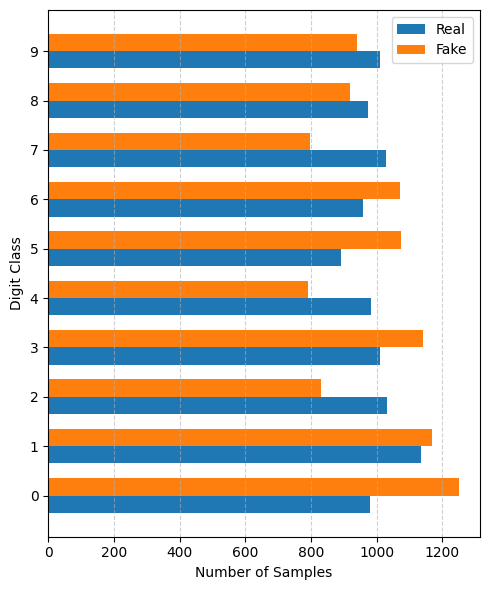

In [ ]:
import matplotlib.pyplot as plt
import torch

# 1. Real dataset labels
real_labels = torch.tensor(mnist_test_dataset.targets)  # MNIST test set labels

# 2. Fake dataset labels
fake_labels = predicted_labels

# 3. Count occurrences
real_counts = torch.bincount(real_labels, minlength=10)
fake_counts = torch.bincount(fake_labels, minlength=10)

# 4. Plot
classes = list(range(10))
width = 0.35  # bar width

plt.figure(figsize=(5, 6))
plt.barh(
    [c - width/2 for c in classes], real_counts, height=width, label="Real"
)
plt.barh(
    [c + width/2 for c in classes], fake_counts, height=width, label="Fake"
)

plt.ylabel("Digit Class")
plt.xlabel("Number of Samples")
# plt.title("Class Distribution using VP ODE Diffusion: Real vs. Fake MNIST")
plt.yticks(classes)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Print class distributions
print(f"{'Class':<6} | {'Real Count':<12} | {'Fake Count':<12}")
print("-" * 36)
for i in range(10):
    print(f"{i:<6} | {real_counts[i].item():<12} | {fake_counts[i].item():<12}")

Class  | Real Count   | Fake Count  
------------------------------------
0      | 980          | 1252        
1      | 1135         | 1168        
2      | 1032         | 830         
3      | 1010         | 1141        
4      | 982          | 790         
5      | 892          | 1075        
6      | 958          | 1072        
7      | 1028         | 798         
8      | 974          | 919         
9      | 1009         | 939         


# CIFAR10

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Tranformation for the CIFAR10
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Download the dataset
cifar10_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=64, shuffle=False)

print(f"\nNumber of images of the test set: {len(cifar10_test_dataset)}")
print(f"\nNumber of batches of the test set: {len(cifar10_test_loader)}")


Number of images of the test set: 10000

Number of batches of the test set: 157


## FID

In [ ]:
from utils.unet import UNetModel

channels = 3
out_channels = 3

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes= None,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

### 1. VP Deterministic

In [ ]:
model.load_state_dict(torch.load("trained/cifar_VP_unconditioned.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import math

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm + s) / (1 + s)) * (torch.pi / 2))
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

def score_fn(model, x, t_norm):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm)
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, schedule = 'linear', T = 1, gif = False):
    shape = (n_samples, 3, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)


            # Get the score (using the noise-predicting network)
            score = score_fn(model, xt, t_batch)

            # Euler–Maruyama update:
            xt = xt + (f - (g**2) * score / 2) * dt

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

total_samples = len(cifar10_test_dataset)
batch_size = 64
num_batches = total_samples // batch_size

generated_images = []

# Generate all batches
for batch_idx in range(num_batches):
    print(f"Generating batch {batch_idx + 1}/{num_batches}")
    samples = sample(
        model=model,
        n_samples=batch_size,
        reverse_steps=500,
        T=1,
        gif=False
    )
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    # Normalize images to [0, 1]
    final_step_images = (final_step_images - final_step_images.min()) / (final_step_images.max() - final_step_images.min())
    generated_images.append(final_step_images)

# Stack all generated images
generated_images = torch.cat(generated_images, dim=0)
print(f"Generated images shape: {generated_images.shape}")

Generating batch 1/156


100%|██████████| 500/500 [00:20<00:00, 24.32it/s]
<ipython-input-21-40b7e5a4b64f>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


Generating batch 2/156


100%|██████████| 500/500 [00:20<00:00, 24.84it/s]


Generating batch 3/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 4/156


100%|██████████| 500/500 [00:20<00:00, 24.56it/s]


Generating batch 5/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 6/156


100%|██████████| 500/500 [00:20<00:00, 24.50it/s]


Generating batch 7/156


100%|██████████| 500/500 [00:23<00:00, 21.41it/s]


Generating batch 8/156


100%|██████████| 500/500 [00:22<00:00, 22.20it/s]


Generating batch 9/156


100%|██████████| 500/500 [00:20<00:00, 24.07it/s]


Generating batch 10/156


100%|██████████| 500/500 [00:20<00:00, 24.61it/s]


Generating batch 11/156


100%|██████████| 500/500 [00:20<00:00, 24.07it/s]


Generating batch 12/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 13/156


100%|██████████| 500/500 [00:22<00:00, 21.91it/s]


Generating batch 14/156


100%|██████████| 500/500 [00:25<00:00, 19.77it/s]


Generating batch 15/156


100%|██████████| 500/500 [00:20<00:00, 24.53it/s]


Generating batch 16/156


100%|██████████| 500/500 [00:20<00:00, 24.55it/s]


Generating batch 17/156


100%|██████████| 500/500 [00:20<00:00, 23.93it/s]


Generating batch 18/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 19/156


100%|██████████| 500/500 [00:24<00:00, 20.62it/s]


Generating batch 20/156


100%|██████████| 500/500 [00:20<00:00, 24.39it/s]


Generating batch 21/156


100%|██████████| 500/500 [00:20<00:00, 24.17it/s]


Generating batch 22/156


100%|██████████| 500/500 [00:20<00:00, 24.18it/s]


Generating batch 23/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 24/156


100%|██████████| 500/500 [00:21<00:00, 23.20it/s]


Generating batch 25/156


100%|██████████| 500/500 [00:19<00:00, 25.12it/s]


Generating batch 26/156


100%|██████████| 500/500 [00:20<00:00, 24.52it/s]


Generating batch 27/156


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Generating batch 28/156


100%|██████████| 500/500 [00:20<00:00, 24.80it/s]


Generating batch 29/156


100%|██████████| 500/500 [00:20<00:00, 24.04it/s]


Generating batch 30/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 31/156


100%|██████████| 500/500 [00:20<00:00, 24.09it/s]


Generating batch 32/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 33/156


100%|██████████| 500/500 [00:20<00:00, 24.29it/s]


Generating batch 34/156


100%|██████████| 500/500 [00:20<00:00, 24.86it/s]


Generating batch 35/156


100%|██████████| 500/500 [00:20<00:00, 24.49it/s]


Generating batch 36/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 37/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 38/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 39/156


100%|██████████| 500/500 [00:24<00:00, 20.56it/s]


Generating batch 40/156


100%|██████████| 500/500 [00:25<00:00, 19.61it/s]


Generating batch 41/156


100%|██████████| 500/500 [00:27<00:00, 18.49it/s]


Generating batch 42/156


100%|██████████| 500/500 [00:25<00:00, 19.71it/s]


Generating batch 43/156


100%|██████████| 500/500 [00:22<00:00, 22.37it/s]


Generating batch 44/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 45/156


100%|██████████| 500/500 [00:21<00:00, 23.73it/s]


Generating batch 46/156


100%|██████████| 500/500 [00:20<00:00, 24.29it/s]


Generating batch 47/156


100%|██████████| 500/500 [00:22<00:00, 22.42it/s]


Generating batch 48/156


100%|██████████| 500/500 [00:21<00:00, 23.43it/s]


Generating batch 49/156


100%|██████████| 500/500 [00:22<00:00, 22.32it/s]


Generating batch 50/156


100%|██████████| 500/500 [00:20<00:00, 24.31it/s]


Generating batch 51/156


100%|██████████| 500/500 [00:27<00:00, 18.42it/s]


Generating batch 52/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 53/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 54/156


100%|██████████| 500/500 [00:20<00:00, 24.33it/s]


Generating batch 55/156


100%|██████████| 500/500 [00:21<00:00, 23.57it/s]


Generating batch 56/156


100%|██████████| 500/500 [00:21<00:00, 23.61it/s]


Generating batch 57/156


100%|██████████| 500/500 [00:22<00:00, 22.13it/s]


Generating batch 58/156


100%|██████████| 500/500 [00:20<00:00, 24.40it/s]


Generating batch 59/156


100%|██████████| 500/500 [00:20<00:00, 24.30it/s]


Generating batch 60/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 61/156


100%|██████████| 500/500 [00:21<00:00, 23.74it/s]


Generating batch 62/156


100%|██████████| 500/500 [00:20<00:00, 24.89it/s]


Generating batch 63/156


100%|██████████| 500/500 [00:20<00:00, 24.32it/s]


Generating batch 64/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 65/156


100%|██████████| 500/500 [00:20<00:00, 24.41it/s]


Generating batch 66/156


100%|██████████| 500/500 [00:20<00:00, 24.56it/s]


Generating batch 67/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 68/156


100%|██████████| 500/500 [00:20<00:00, 24.48it/s]


Generating batch 69/156


100%|██████████| 500/500 [00:20<00:00, 24.94it/s]


Generating batch 70/156


100%|██████████| 500/500 [00:20<00:00, 24.42it/s]


Generating batch 71/156


100%|██████████| 500/500 [00:19<00:00, 25.16it/s]


Generating batch 72/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 73/156


100%|██████████| 500/500 [00:20<00:00, 24.94it/s]


Generating batch 74/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 75/156


100%|██████████| 500/500 [00:20<00:00, 24.83it/s]


Generating batch 76/156


100%|██████████| 500/500 [00:20<00:00, 24.47it/s]


Generating batch 77/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 78/156


100%|██████████| 500/500 [00:20<00:00, 24.47it/s]


Generating batch 79/156


100%|██████████| 500/500 [00:20<00:00, 24.19it/s]


Generating batch 80/156


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Generating batch 81/156


100%|██████████| 500/500 [00:20<00:00, 24.51it/s]


Generating batch 82/156


100%|██████████| 500/500 [00:19<00:00, 25.01it/s]


Generating batch 83/156


100%|██████████| 500/500 [00:20<00:00, 24.45it/s]


Generating batch 84/156


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Generating batch 85/156


100%|██████████| 500/500 [00:20<00:00, 24.36it/s]


Generating batch 86/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 87/156


100%|██████████| 500/500 [00:20<00:00, 24.46it/s]


Generating batch 88/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 89/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 90/156


100%|██████████| 500/500 [00:20<00:00, 24.50it/s]


Generating batch 91/156


100%|██████████| 500/500 [00:19<00:00, 25.05it/s]


Generating batch 92/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 93/156


100%|██████████| 500/500 [00:19<00:00, 25.11it/s]


Generating batch 94/156


100%|██████████| 500/500 [00:20<00:00, 24.53it/s]


Generating batch 95/156


100%|██████████| 500/500 [00:20<00:00, 24.98it/s]


Generating batch 96/156


100%|██████████| 500/500 [00:20<00:00, 24.45it/s]


Generating batch 97/156


100%|██████████| 500/500 [00:20<00:00, 24.82it/s]


Generating batch 98/156


100%|██████████| 500/500 [00:20<00:00, 24.48it/s]


Generating batch 99/156


100%|██████████| 500/500 [00:20<00:00, 24.63it/s]


Generating batch 100/156


100%|██████████| 500/500 [00:20<00:00, 24.67it/s]


Generating batch 101/156


100%|██████████| 500/500 [00:20<00:00, 24.42it/s]


Generating batch 102/156


100%|██████████| 500/500 [00:19<00:00, 25.01it/s]


Generating batch 103/156


100%|██████████| 500/500 [00:20<00:00, 24.65it/s]


Generating batch 104/156


100%|██████████| 500/500 [00:19<00:00, 25.02it/s]


Generating batch 105/156


100%|██████████| 500/500 [00:20<00:00, 24.37it/s]


Generating batch 106/156


100%|██████████| 500/500 [00:19<00:00, 25.06it/s]


Generating batch 107/156


100%|██████████| 500/500 [00:20<00:00, 24.42it/s]


Generating batch 108/156


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Generating batch 109/156


100%|██████████| 500/500 [00:20<00:00, 24.52it/s]


Generating batch 110/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 111/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 112/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 113/156


100%|██████████| 500/500 [00:19<00:00, 25.06it/s]


Generating batch 114/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 115/156


100%|██████████| 500/500 [00:20<00:00, 24.97it/s]


Generating batch 116/156


100%|██████████| 500/500 [00:20<00:00, 24.53it/s]


Generating batch 117/156


100%|██████████| 500/500 [00:20<00:00, 24.88it/s]


Generating batch 118/156


100%|██████████| 500/500 [00:20<00:00, 24.46it/s]


Generating batch 119/156


100%|██████████| 500/500 [00:19<00:00, 25.00it/s]


Generating batch 120/156


100%|██████████| 500/500 [00:20<00:00, 24.41it/s]


Generating batch 121/156


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Generating batch 122/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 123/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 124/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 125/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 126/156


100%|██████████| 500/500 [00:19<00:00, 25.01it/s]


Generating batch 127/156


100%|██████████| 500/500 [00:20<00:00, 24.39it/s]


Generating batch 128/156


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Generating batch 129/156


100%|██████████| 500/500 [00:20<00:00, 24.39it/s]


Generating batch 130/156


100%|██████████| 500/500 [00:20<00:00, 24.84it/s]


Generating batch 131/156


100%|██████████| 500/500 [00:20<00:00, 24.37it/s]


Generating batch 132/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 133/156


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Generating batch 134/156


100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


Generating batch 135/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 136/156


100%|██████████| 500/500 [00:20<00:00, 24.47it/s]


Generating batch 137/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 138/156


100%|██████████| 500/500 [00:20<00:00, 24.38it/s]


Generating batch 139/156


100%|██████████| 500/500 [00:20<00:00, 24.83it/s]


Generating batch 140/156


100%|██████████| 500/500 [00:20<00:00, 24.26it/s]


Generating batch 141/156


100%|██████████| 500/500 [00:20<00:00, 24.88it/s]


Generating batch 142/156


100%|██████████| 500/500 [00:20<00:00, 24.35it/s]


Generating batch 143/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 144/156


100%|██████████| 500/500 [00:20<00:00, 24.80it/s]


Generating batch 145/156


100%|██████████| 500/500 [00:20<00:00, 24.63it/s]


Generating batch 146/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 147/156


100%|██████████| 500/500 [00:20<00:00, 24.45it/s]


Generating batch 148/156


100%|██████████| 500/500 [00:19<00:00, 25.09it/s]


Generating batch 149/156


100%|██████████| 500/500 [00:20<00:00, 24.41it/s]


Generating batch 150/156


100%|██████████| 500/500 [00:20<00:00, 24.90it/s]


Generating batch 151/156


100%|██████████| 500/500 [00:20<00:00, 24.39it/s]


Generating batch 152/156


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Generating batch 153/156


100%|██████████| 500/500 [00:20<00:00, 24.44it/s]


Generating batch 154/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 155/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 156/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]

Generated images shape: torch.Size([9984, 1, 32, 32])


In [ ]:
import torchmetrics as tm

fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)


for batch in cifar10_test_loader:
    images, _ = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
        # print(f"Fake:{images.min()}, {images.max()}")
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=True)

# Resize generated images
generated_images = F.interpolate(generated_images, size=(299, 299), mode='bilinear', align_corners=False)

# Make fake_loader
fake_dataset = TensorDataset(generated_images)
fake_loader = DataLoader(fake_dataset, batch_size=64, shuffle=False)

for batch in fake_loader:
    (images,) = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
        # print(f"Fake:{images.min()}, {images.max()}")
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=False)

fid_score = fid.compute()
print(f"FID Score: {fid_score.item()}")

Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0.0, 1.0
Real:0

### 2. VP Stochastic

In [ ]:
model.load_state_dict(torch.load("trained/cifar_VP_unconditioned.pth"))

In [ ]:
from tqdm import tqdm
import math
import torch

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm + s) / (1 + s)) * (torch.pi / 2))
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

def score_fn(model, x, t_norm):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm)
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, schedule = 'linear', T = 1, gif = False):
    shape = (n_samples, 3, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)


            # Get the score (using the noise-predicting network)
            score = score_fn(model, xt, t_batch)

            # Euler–Maruyama update:
            z = torch.randn_like(xt)
            xt = xt + (f - (g**2) * score) * dt + g * torch.sqrt(-dt) * z

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

total_samples = len(cifar10_test_dataset)
batch_size = 64
num_batches = total_samples // batch_size

generated_images = []

# Generate all batches
for batch_idx in range(num_batches):
    print(f"Generating batch {batch_idx + 1}/{num_batches}")
    samples = sample(
        model=model,
        n_samples=batch_size,
        reverse_steps=500,
        T=1,
        gif=False
    )
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    # Normalize images to [0, 1]
    final_step_images = (final_step_images - final_step_images.min()) / (final_step_images.max() - final_step_images.min())
    generated_images.append(final_step_images)

# Stack all generated images
generated_images = torch.cat(generated_images, dim=0)
print(f"Generated images shape: {generated_images.shape}")

In [ ]:
import torchmetrics as tm

fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)


for batch in cifar10_test_loader:
    images, _ = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=True)

# Resize generated images
generated_images = F.interpolate(generated_images, size=(299, 299), mode='bilinear', align_corners=False)

# Make fake_loader
fake_dataset = TensorDataset(generated_images)
fake_loader = DataLoader(fake_dataset, batch_size=64, shuffle=False)

for batch in fake_loader:
    (images,) = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=False)

fid_score = fid.compute()
print(f"FID Score: {fid_score.item()}")

### 3. Flow Matching

In [ ]:
model.load_state_dict(torch.load("trained/cifar_flow_matching_unconditioned.pth"))

In [ ]:
from tqdm import tqdm

def sample(model, n_samples, steps, T = 1, gif = False):
    shape = (n_samples, 3, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_norm_batch = t_batch / T

            xt = xt + (T / steps) * model(xt, t_norm_batch)

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

total_samples = len(cifar10_test_dataset)
batch_size = 64
num_batches = total_samples // batch_size

generated_images = []

# Generate all batches
for batch_idx in range(num_batches):
    print(f"Generating batch {batch_idx + 1}/{num_batches}")
    samples = sample(
        model=model,
        n_samples=batch_size,
        steps=500,
        T=1,
        gif=False
    )
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    # Normalize images to [0, 1]
    final_step_images = (final_step_images - final_step_images.min()) / (final_step_images.max() - final_step_images.min())
    generated_images.append(final_step_images)

# Stack all generated images
generated_images = torch.cat(generated_images, dim=0)
print(f"Generated images shape: {generated_images.shape}")

In [ ]:
import torchmetrics as tm

fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)


for batch in cifar10_test_loader:
    images, _ = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=True)

# Resize generated images
generated_images = F.interpolate(generated_images, size=(299, 299), mode='bilinear', align_corners=False)

# Make fake_loader
fake_dataset = TensorDataset(generated_images)
fake_loader = DataLoader(fake_dataset, batch_size=64, shuffle=False)

for batch in fake_loader:
    (images,) = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=False)

fid_score = fid.compute()
print(f"FID Score: {fid_score.item()}")

### 4. Bridge Matching

In [ ]:
model.load_state_dict(torch.load("trained/cifar_bridge_matching_unconditioned.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import numpy as np

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def sample(model, n_samples, steps, T = 1, sigma=0.5, gif = False):
    shape = (n_samples, 3, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(0, T, steps + 1, device=device)
        for i in tqdm(range(steps)):
            t = t_seq[i]
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t, device=device)
            t_comp = match_last_dims(t_batch, xt.shape)
            t_norm_batch = t_batch / T
            noise = torch.randn_like(xt)

            # Predict the clean x_t
            v = (model(xt, t_norm_batch) - xt) / (1 - t_comp + 1e-5)

            xt = xt + (T / steps) * v + np.sqrt(T / steps) * sigma * noise

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

total_samples = len(cifar10_test_dataset)
batch_size = 64
num_batches = total_samples // batch_size

generated_images = []

# Generate all batches
for batch_idx in range(num_batches):
    print(f"Generating batch {batch_idx + 1}/{num_batches}")
    samples = sample(
        model=model,
        n_samples=batch_size,
        steps=500,
        T=1,
        sigma=0.5,
        gif=False
    )
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    # Normalize images to [0, 1]
    final_step_images = (final_step_images - final_step_images.min()) / (final_step_images.max() - final_step_images.min())
    generated_images.append(final_step_images)

# Stack all generated images
generated_images = torch.cat(generated_images, dim=0)
print(f"Generated images shape: {generated_images.shape}")

Generating batch 1/156


100%|██████████| 500/500 [00:20<00:00, 24.61it/s]
<ipython-input-21-312cb77d2bf1>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


Generating batch 2/156


100%|██████████| 500/500 [00:20<00:00, 24.32it/s]


Generating batch 3/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 4/156


100%|██████████| 500/500 [00:19<00:00, 25.18it/s]


Generating batch 5/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 6/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 7/156


100%|██████████| 500/500 [00:20<00:00, 24.64it/s]


Generating batch 8/156


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Generating batch 9/156


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Generating batch 10/156


100%|██████████| 500/500 [00:20<00:00, 24.84it/s]


Generating batch 11/156


100%|██████████| 500/500 [00:20<00:00, 24.86it/s]


Generating batch 12/156


100%|██████████| 500/500 [00:20<00:00, 24.64it/s]


Generating batch 13/156


100%|██████████| 500/500 [00:19<00:00, 25.07it/s]


Generating batch 14/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 15/156


100%|██████████| 500/500 [00:19<00:00, 25.03it/s]


Generating batch 16/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 17/156


100%|██████████| 500/500 [00:19<00:00, 25.08it/s]


Generating batch 18/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 19/156


100%|██████████| 500/500 [00:19<00:00, 25.04it/s]


Generating batch 20/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 21/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 22/156


100%|██████████| 500/500 [00:20<00:00, 24.76it/s]


Generating batch 23/156


100%|██████████| 500/500 [00:20<00:00, 24.89it/s]


Generating batch 24/156


100%|██████████| 500/500 [00:20<00:00, 24.85it/s]


Generating batch 25/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 26/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 27/156


100%|██████████| 500/500 [00:20<00:00, 24.48it/s]


Generating batch 28/156


100%|██████████| 500/500 [00:20<00:00, 24.76it/s]


Generating batch 29/156


100%|██████████| 500/500 [00:20<00:00, 24.40it/s]


Generating batch 30/156


100%|██████████| 500/500 [00:19<00:00, 25.03it/s]


Generating batch 31/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 32/156


100%|██████████| 500/500 [00:19<00:00, 25.04it/s]


Generating batch 33/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 34/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 35/156


100%|██████████| 500/500 [00:20<00:00, 24.75it/s]


Generating batch 36/156


100%|██████████| 500/500 [00:20<00:00, 24.78it/s]


Generating batch 37/156


100%|██████████| 500/500 [00:20<00:00, 24.80it/s]


Generating batch 38/156


100%|██████████| 500/500 [00:20<00:00, 24.46it/s]


Generating batch 39/156


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Generating batch 40/156


100%|██████████| 500/500 [00:20<00:00, 24.54it/s]


Generating batch 41/156


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Generating batch 42/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 43/156


100%|██████████| 500/500 [00:19<00:00, 25.00it/s]


Generating batch 44/156


100%|██████████| 500/500 [00:20<00:00, 24.52it/s]


Generating batch 45/156


100%|██████████| 500/500 [00:19<00:00, 25.01it/s]


Generating batch 46/156


100%|██████████| 500/500 [00:20<00:00, 24.55it/s]


Generating batch 47/156


100%|██████████| 500/500 [00:20<00:00, 24.82it/s]


Generating batch 48/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 49/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 50/156


100%|██████████| 500/500 [00:20<00:00, 24.77it/s]


Generating batch 51/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 52/156


100%|██████████| 500/500 [00:19<00:00, 25.09it/s]


Generating batch 53/156


100%|██████████| 500/500 [00:20<00:00, 24.65it/s]


Generating batch 54/156


100%|██████████| 500/500 [00:19<00:00, 25.03it/s]


Generating batch 55/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 56/156


100%|██████████| 500/500 [00:19<00:00, 25.02it/s]


Generating batch 57/156


100%|██████████| 500/500 [00:20<00:00, 24.61it/s]


Generating batch 58/156


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Generating batch 59/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 60/156


100%|██████████| 500/500 [00:20<00:00, 24.84it/s]


Generating batch 61/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 62/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 63/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 64/156


100%|██████████| 500/500 [00:20<00:00, 24.63it/s]


Generating batch 65/156


100%|██████████| 500/500 [00:19<00:00, 25.00it/s]


Generating batch 66/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 67/156


100%|██████████| 500/500 [00:19<00:00, 25.04it/s]


Generating batch 68/156


100%|██████████| 500/500 [00:20<00:00, 24.67it/s]


Generating batch 69/156


100%|██████████| 500/500 [00:19<00:00, 25.07it/s]


Generating batch 70/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 71/156


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Generating batch 72/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 73/156


100%|██████████| 500/500 [00:20<00:00, 24.89it/s]


Generating batch 74/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 75/156


100%|██████████| 500/500 [00:20<00:00, 24.78it/s]


Generating batch 76/156


100%|██████████| 500/500 [00:20<00:00, 24.89it/s]


Generating batch 77/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 78/156


100%|██████████| 500/500 [00:19<00:00, 25.00it/s]


Generating batch 79/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 80/156


100%|██████████| 500/500 [00:20<00:00, 25.00it/s]


Generating batch 81/156


100%|██████████| 500/500 [00:20<00:00, 24.61it/s]


Generating batch 82/156


100%|██████████| 500/500 [00:20<00:00, 24.97it/s]


Generating batch 83/156


100%|██████████| 500/500 [00:20<00:00, 24.61it/s]


Generating batch 84/156


100%|██████████| 500/500 [00:20<00:00, 25.00it/s]


Generating batch 85/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 86/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 87/156


100%|██████████| 500/500 [00:20<00:00, 24.85it/s]


Generating batch 88/156


100%|██████████| 500/500 [00:20<00:00, 24.81it/s]


Generating batch 89/156


100%|██████████| 500/500 [00:20<00:00, 24.89it/s]


Generating batch 90/156


100%|██████████| 500/500 [00:20<00:00, 24.66it/s]


Generating batch 91/156


100%|██████████| 500/500 [00:19<00:00, 25.04it/s]


Generating batch 92/156


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Generating batch 93/156


100%|██████████| 500/500 [00:19<00:00, 25.02it/s]


Generating batch 94/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 95/156


100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Generating batch 96/156


100%|██████████| 500/500 [00:20<00:00, 24.57it/s]


Generating batch 97/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 98/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 99/156


100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


Generating batch 100/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 101/156


100%|██████████| 500/500 [00:20<00:00, 24.65it/s]


Generating batch 102/156


100%|██████████| 500/500 [00:20<00:00, 24.87it/s]


Generating batch 103/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 104/156


100%|██████████| 500/500 [00:19<00:00, 25.05it/s]


Generating batch 105/156


100%|██████████| 500/500 [00:20<00:00, 24.56it/s]


Generating batch 106/156


100%|██████████| 500/500 [00:20<00:00, 24.98it/s]


Generating batch 107/156


100%|██████████| 500/500 [00:20<00:00, 24.55it/s]


Generating batch 108/156


100%|██████████| 500/500 [00:20<00:00, 24.94it/s]


Generating batch 109/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 110/156


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Generating batch 111/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 112/156


100%|██████████| 500/500 [00:20<00:00, 24.86it/s]


Generating batch 113/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 114/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 115/156


100%|██████████| 500/500 [00:20<00:00, 24.85it/s]


Generating batch 116/156


100%|██████████| 500/500 [00:20<00:00, 24.55it/s]


Generating batch 117/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 118/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 119/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 120/156


100%|██████████| 500/500 [00:20<00:00, 24.54it/s]


Generating batch 121/156


100%|██████████| 500/500 [00:20<00:00, 24.88it/s]


Generating batch 122/156


100%|██████████| 500/500 [00:20<00:00, 24.54it/s]


Generating batch 123/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 124/156


100%|██████████| 500/500 [00:20<00:00, 24.54it/s]


Generating batch 125/156


100%|██████████| 500/500 [00:20<00:00, 24.45it/s]


Generating batch 126/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 127/156


100%|██████████| 500/500 [00:20<00:00, 24.65it/s]


Generating batch 128/156


100%|██████████| 500/500 [00:20<00:00, 24.92it/s]


Generating batch 129/156


100%|██████████| 500/500 [00:20<00:00, 24.60it/s]


Generating batch 130/156


100%|██████████| 500/500 [00:20<00:00, 24.94it/s]


Generating batch 131/156


100%|██████████| 500/500 [00:20<00:00, 24.59it/s]


Generating batch 132/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 133/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 134/156


100%|██████████| 500/500 [00:20<00:00, 24.71it/s]


Generating batch 135/156


100%|██████████| 500/500 [00:20<00:00, 24.87it/s]


Generating batch 136/156


100%|██████████| 500/500 [00:20<00:00, 24.64it/s]


Generating batch 137/156


100%|██████████| 500/500 [00:19<00:00, 25.12it/s]


Generating batch 138/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 139/156


100%|██████████| 500/500 [00:19<00:00, 25.04it/s]


Generating batch 140/156


100%|██████████| 500/500 [00:20<00:00, 24.70it/s]


Generating batch 141/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 142/156


100%|██████████| 500/500 [00:20<00:00, 24.68it/s]


Generating batch 143/156


100%|██████████| 500/500 [00:20<00:00, 24.78it/s]


Generating batch 144/156


100%|██████████| 500/500 [00:20<00:00, 24.91it/s]


Generating batch 145/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 146/156


100%|██████████| 500/500 [00:19<00:00, 25.01it/s]


Generating batch 147/156


100%|██████████| 500/500 [00:20<00:00, 24.63it/s]


Generating batch 148/156


100%|██████████| 500/500 [00:19<00:00, 25.05it/s]


Generating batch 149/156


100%|██████████| 500/500 [00:20<00:00, 24.69it/s]


Generating batch 150/156


100%|██████████| 500/500 [00:20<00:00, 24.96it/s]


Generating batch 151/156


100%|██████████| 500/500 [00:20<00:00, 24.72it/s]


Generating batch 152/156


100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


Generating batch 153/156


100%|██████████| 500/500 [00:20<00:00, 24.97it/s]


Generating batch 154/156


100%|██████████| 500/500 [00:20<00:00, 24.73it/s]


Generating batch 155/156


100%|██████████| 500/500 [00:19<00:00, 25.07it/s]


Generating batch 156/156


100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Generated images shape: torch.Size([9984, 1, 32, 32])


In [ ]:
import torchmetrics as tm

fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)


for batch in cifar10_test_loader:
    images, _ = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=True)

# Resize generated images
generated_images = F.interpolate(generated_images, size=(299, 299), mode='bilinear', align_corners=False)

# Make fake_loader
fake_dataset = TensorDataset(generated_images)
fake_loader = DataLoader(fake_dataset, batch_size=64, shuffle=False)

for batch in fake_loader:
    (images,) = batch
    if images.shape[1] == 1:  # if grayscale, repeat channels
        images = images.repeat(1, 3, 1, 1)
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(images.to(device), real=False)

fid_score = fid.compute()
print(f"FID Score: {fid_score.item()}")

## cFID

In [ ]:
from utils.unet import UNetModel

channels = 3
out_channels = 3

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value

model = UNetModel(
        in_channels=channels,
        model_channels=32,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= [2, 4],# tuple([2, 4]), # adds attention at image_size / 2 and /4
        dropout= 0.0,
        channel_mult= [1, 2, 2, 2], # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes= 10,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim,
    )

model = model.to(device)

### 1. VP Deterministic

In [ ]:
model.load_state_dict(torch.load("trained/cifar_VP_conditioned.pth"))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm
import math

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm + s) / (1 + s)) * (torch.pi / 2))
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

def score_fn(model, x, t_norm, y):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm, y)
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, class_label, schedule = 'linear', T = 1, gif = False):
    shape = (n_samples, 3, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)

            # Compute conditional score
            cond_class_label = torch.full((shape[0],), class_label, device=device)
            score_cond = score_fn(model, xt, t_batch, cond_class_label)

            # Euler–Maruyama update:
            xt = xt + (f - (g**2) * score_cond / 2) * dt

            all_images.append(xt)

    return xt if not gif else all_images

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchmetrics as tm
from collections import defaultdict

# Prepare per-class real image buffers
real_images_by_class = defaultdict(list)
for images, labels in cifar10_test_loader:
    for i in range(10):
        mask = labels == i
        class_images = images[mask]
        if class_images.shape[1] == 1:
            class_images = class_images.repeat(1, 3, 1, 1)
        real_images_by_class[i].append(class_images)

for k in real_images_by_class:
    real_images_by_class[k] = torch.cat(real_images_by_class[k], dim=0)

In [ ]:
# Generate conditional images per class
generated_images_by_class = defaultdict(list)
n_samples_per_class = len(cifar10_test_dataset) // 10
batch_size = 64

for class_label in range(10):
    num_batches = n_samples_per_class // batch_size
    for batch_idx in range(num_batches):
        print(f"Generating class {class_label} batch {batch_idx + 1}/{num_batches}")
        samples = sample(
            model=model,
            n_samples=batch_size,
            reverse_steps=500,
            T=1,
            gif=False,
            class_label=class_label  # Pass class label here
        )
        images = torch.stack([torch.tensor(s).cpu() for s in samples])
        images = (images - images.min()) / (images.max() - images.min())  # Normalize to [0,1]
        generated_images_by_class[class_label].append(images)

    generated_images_by_class[class_label] = torch.cat(generated_images_by_class[class_label], dim=0)

In [ ]:
# Compute cFID per class
fid_scores = []
for class_label in range(10):
    fid = tm.image.fid.FrechetInceptionDistance(feature=2048).to(device)

    # Real images
    real_images = real_images_by_class[class_label]
    real_images = (real_images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(real_images.to(device), real=True)

    # Generated images
    fake_images = generated_images_by_class[class_label]
    fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)
    fake_images = fake_images.repeat(1, 3, 1, 1) if fake_images.shape[1] == 1 else fake_images
    fake_images = (fake_images * 255).clamp(0, 255).to(torch.uint8)
    fid.update(fake_images.to(device), real=False)

    score = fid.compute().item()
    fid_scores.append(score)
    print(f"FID for class {class_label}: {score:.4f}")

# Average FID across all classes
cfid_score = sum(fid_scores) / len(fid_scores)
print(f"\nConditional FID (cFID): {cfid_score:.4f}")

## Classification

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualSEBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.SiLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)
        self.act2 = nn.SiLU()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        return self.act2(out)

class CIFAR10ResSE(nn.Module):
    def __init__(self):
        super(CIFAR10ResSE, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.SiLU()
        )
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _make_layer(self, in_ch, out_ch, blocks, stride):
        layers = [ResidualSEBlock(in_ch, out_ch, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualSEBlock(out_ch, out_ch))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)   # 32x32
        x = self.layer2(x)   # 16x16
        x = self.layer3(x)   # 8x8
        x = self.layer4(x)   # 4x4
        x = self.pool(x).view(x.size(0), -1)
        return self.classifier(x)

model = CIFAR10ResSE().to(device)

In [ ]:
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Simple training loop
for epoch in range(20):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} done.")

Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.
Epoch 11 done.
Epoch 12 done.
Epoch 13 done.
Epoch 14 done.
Epoch 15 done.
Epoch 16 done.
Epoch 17 done.
Epoch 18 done.
Epoch 19 done.
Epoch 20 done.


In [ ]:
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

test_dataset = CIFAR10(root='./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
from sklearn.metrics import f1_score
import torch

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

In [ ]:
from sklearn.metrics import classification_report

print("F1 Scores:")
print(classification_report(all_labels, all_preds, digits=4))

F1 Scores:
              precision    recall  f1-score   support

           0     0.8763    0.8500    0.8629      1000
           1     0.9348    0.9180    0.9263      1000
           2     0.7667    0.8050    0.7854      1000
           3     0.7506    0.6590    0.7018      1000
           4     0.8403    0.8260    0.8331      1000
           5     0.7344    0.8350    0.7815      1000
           6     0.8492    0.9120    0.8795      1000
           7     0.9317    0.7910    0.8556      1000
           8     0.8900    0.9300    0.9095      1000
           9     0.8886    0.9170    0.9026      1000

    accuracy                         0.8443     10000
   macro avg     0.8462    0.8443    0.8438     10000
weighted avg     0.8462    0.8443    0.8438     10000



In [ ]:
# Save model weights
torch.save(model.state_dict(), "trained/cifar_classifier.pth")

## Distribution of classes

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualSEBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.SiLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)
        self.act2 = nn.SiLU()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        return self.act2(out)

class CIFAR10ResSE(nn.Module):
    def __init__(self):
        super(CIFAR10ResSE, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.SiLU()
        )
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _make_layer(self, in_ch, out_ch, blocks, stride):
        layers = [ResidualSEBlock(in_ch, out_ch, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualSEBlock(out_ch, out_ch))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)   # 32x32
        x = self.layer2(x)   # 16x16
        x = self.layer3(x)   # 8x8
        x = self.layer4(x)   # 4x4
        x = self.pool(x).view(x.size(0), -1)
        return self.classifier(x)

model = CIFAR10ResSE().to(device)
model.load_state_dict(torch.load("trained/cifar_classifier.pth"))

<All keys matched successfully>

In [12]:
from utils.unet import UNetModel

channels = 3
out_channels = 3 # or 6

first_layer_embedding = False
embedding_dim = 3 # MD4 needs a value for masks, so set of values is {0, 1, 2}
output_dim = 1 # We only output a single probability value
attention_ds = (8,16)

unet = UNetModel(
        in_channels=channels,
        model_channels=128,
        out_channels= out_channels,
        num_res_blocks=2,
        attention_resolutions= attention_ds,
        dropout= 0.3,
        channel_mult= (1, 2, 2, 2), # divides image_size by two at each new item, except first one. [i] * model_channels
        dims = 2, # for images
        num_classes= None,#
        num_heads=4,
        num_heads_upsample=-1, # same as num_heads
        use_scale_shift_norm=True,
        first_layer_embedding=first_layer_embedding,
        embedding_dim= embedding_dim,
        output_dim = output_dim
    )

unet = unet.to(device)

### VP

In [13]:
unet.load_state_dict(torch.load("trained/cifar_VP_unconditioned.pth"))

<All keys matched successfully>

In [14]:
from tqdm import tqdm
import math

def match_last_dims(data, shape):
    """
    Repeat a 1D tensor so that its last dimensions [1:] match `size[1:]`.
    Useful for working with batched data.
    """
    assert len(data.shape) == 1, "Data must be 1-dimensional (one value per batch)"
    for _ in range(len(shape) - 1):
        data = data.unsqueeze(-1)
    return data.repeat(1, *(shape[1:]))

def compute_beta_t(t_norm, T, schedule = 'linear'):
    # Compute β(t) depending on schedule.
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        beta_t = beta_min + t_norm * (beta_max - beta_min)
    elif schedule == 'cosine':
        s = 0.008
        beta_t = (torch.pi / (T * (1 + s))) * torch.tan(((t_norm + s) / (1 + s)) * (torch.pi / 2))
    else:
        raise ValueError('Unknown schedule')
    return beta_t

def compute_alpha_bar(t_norm, schedule = 'linear'):
    if schedule == 'linear':
        beta_min = 0.1
        beta_max = 20.0
        integrated_beta = beta_min * t_norm + 0.5 * (beta_max - beta_min) * t_norm**2
        alpha_bar = torch.exp(-  integrated_beta)
    elif schedule == 'cosine':
        alpha_bar = 0.5 * (1 - torch.cos(t_norm * torch.pi))
        s = 0.008
        alpha_bar = torch.cos((t_norm + s) / (1 + s) * (torch.pi / 2))**2
    else:
        raise ValueError('Unknown schedule')
    return alpha_bar

# must return x_t and the added noise, we will need it later to compute the loss
def forward(x_start, t, T, schedule = 'linear'):
    t_norm = t / T
    alpha_bar = compute_alpha_bar(t_norm, schedule)
    # expand alpha_bar to the same shape as x_start, so that we can multiply them
    alpha_bar = match_last_dims(alpha_bar, x_start.shape)
    noise = torch.randn_like(x_start)
    x_t = torch.sqrt(alpha_bar)*x_start + torch.sqrt(1 - alpha_bar)*noise
    return x_t, noise

def score_fn(model, x, t_norm):
    """
    Given the noise-predicting model, returns the score (i.e. ∇_x log p_t(x))
    at actual time t. Note that the model expects a normalized time (t/T).
    For VP: score = - (predicted noise) / sqrt(1 - ᾱ(t))
    """

    alpha_bar = compute_alpha_bar(t_norm).view(-1, *([1] * (x.dim() - 1)))
    epsilon = model(x, t_norm)
    score = - epsilon / torch.sqrt(1 - alpha_bar)
    return score

def sample(model, n_samples, reverse_steps, schedule = 'linear', T = 1, gif = False):
    shape = (n_samples, 3, 32, 32)
    xt = torch.randn(shape, device=device)
    all_images = []
    model.eval()
    with torch.inference_mode():
        # Create a time discretization from T to 0
        t_seq = torch.linspace(T, 0, reverse_steps + 1, device=device)
        for i in tqdm(range(reverse_steps)):
            t_current = t_seq[i]
            t_next = t_seq[i + 1]
            dt = t_next - t_current  # dt is negative (reverse time)
            # Create a batch of current time values for the update.
            t_batch = torch.full((shape[0],), t_current, device=device)
            t_norm_batch = t_batch / T


            beta_t = compute_beta_t(t_norm_batch, T, schedule)
            beta_t = beta_t.view(-1, *([1] * (xt.dim() - 1)))


            f = -0.5 * beta_t * xt
            g = torch.sqrt(beta_t)


            # Get the score (using the noise-predicting network)
            score = score_fn(model, xt, t_batch)

            # Euler–Maruyama update:
            xt = xt + (f - (g**2) * score / 2) * dt

            all_images.append(xt)

    return xt if not gif else all_images

In [15]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Generate fake images
total_samples = len(cifar10_test_dataset)
batch_size = 64
num_batches = total_samples // batch_size

generated_images = []

for batch_idx in range(num_batches):
    print(f"Generating batch {batch_idx + 1}/{num_batches}")
    samples = sample(
        model=unet,
        n_samples=batch_size,
        reverse_steps=500,
        schedule = 'cosine',
        T=1,
        gif=False
    )
    final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])
    final_step_images = (final_step_images - final_step_images.min()) / (final_step_images.max() - final_step_images.min())  # [0, 1]
    generated_images.append(final_step_images)

generated_images = torch.cat(generated_images, dim=0)  # Shape: [N, 1, 32, 32]
print(f"Generated images shape: {generated_images.shape}")

# Classify using pretrained CNN model
model.eval()
with torch.no_grad():
    inputs = generated_images.to(device)
    outputs = model(inputs)
    predicted_labels = outputs.argmax(dim=1).cpu()

print(f"Predicted labels shape: {predicted_labels.shape}")


Generating batch 1/156


100%|██████████| 500/500 [01:03<00:00,  7.82it/s]
<ipython-input-15-160e63d4c680>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_step_images = torch.stack([torch.tensor(s).cpu() for s in samples])


Generating batch 2/156


100%|██████████| 500/500 [01:05<00:00,  7.68it/s]


Generating batch 3/156


100%|██████████| 500/500 [01:04<00:00,  7.71it/s]


Generating batch 4/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 5/156


100%|██████████| 500/500 [01:05<00:00,  7.69it/s]


Generating batch 6/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 7/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 8/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 9/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 10/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 11/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 12/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 13/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 14/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 15/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 16/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 17/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 18/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 19/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 20/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 21/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 22/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 23/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 24/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 25/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 26/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 27/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 28/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 29/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 30/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 31/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 32/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 33/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 34/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 35/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 36/156


100%|██████████| 500/500 [01:05<00:00,  7.68it/s]


Generating batch 37/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 38/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 39/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 40/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 41/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 42/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 43/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 44/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 45/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 46/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 47/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 48/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 49/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 50/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 51/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 52/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 53/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 54/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 55/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 56/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 57/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 58/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 59/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 60/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 61/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 62/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 63/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 64/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 65/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 66/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 67/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 68/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 69/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 70/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 71/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 72/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 73/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 74/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 75/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 76/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 77/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 78/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 79/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 80/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 81/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 82/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 83/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 84/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 85/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 86/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 87/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 88/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 89/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 90/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 91/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 92/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 93/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 94/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 95/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 96/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 97/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 98/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 99/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 100/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 101/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 102/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 103/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 104/156


100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


Generating batch 105/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 106/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 107/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 108/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 109/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 110/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 111/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 112/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 113/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 114/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 115/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 116/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 117/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 118/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 119/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generating batch 120/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generating batch 121/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 122/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 123/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 124/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 125/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 126/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 127/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 128/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 129/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 130/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generating batch 131/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 132/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generating batch 133/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 134/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 135/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 136/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 137/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generating batch 138/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generating batch 139/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 140/156


100%|██████████| 500/500 [01:04<00:00,  7.77it/s]


Generating batch 141/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generating batch 142/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generating batch 143/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 144/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 145/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 146/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 147/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generating batch 148/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 149/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generating batch 150/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 151/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generating batch 152/156


100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Generating batch 153/156


100%|██████████| 500/500 [01:04<00:00,  7.74it/s]


Generating batch 154/156


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


Generating batch 155/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generating batch 156/156


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


Generated images shape: torch.Size([9984, 3, 32, 32])
Predicted labels shape: torch.Size([9984])


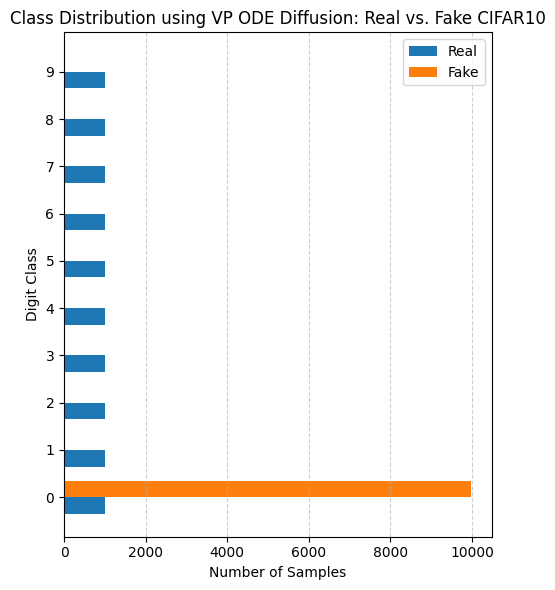

In [16]:
import matplotlib.pyplot as plt
import torch

# 1. Real dataset labels
real_labels = torch.tensor(cifar10_test_dataset.targets)  # CIFAR10 test set labels

# 2. Fake dataset labels
fake_labels = predicted_labels

# 3. Count occurrences
real_counts = torch.bincount(real_labels, minlength=10)
fake_counts = torch.bincount(fake_labels, minlength=10)

# 4. Plot
classes = list(range(10))
width = 0.35  # bar width

plt.figure(figsize=(5, 6))
plt.barh(
    [c - width/2 for c in classes], real_counts, height=width, label="Real"
)
plt.barh(
    [c + width/2 for c in classes], fake_counts, height=width, label="Fake"
)

plt.ylabel("Digit Class")
plt.xlabel("Number of Samples")
plt.title("Class Distribution using VP ODE Diffusion: Real vs. Fake CIFAR10")
plt.yticks(classes)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [17]:
# Print class distributions
print(f"{'Class':<6} | {'Real Count':<12} | {'Fake Count':<12}")
print("-" * 36)
for i in range(10):
    print(f"{i:<6} | {real_counts[i].item():<12} | {fake_counts[i].item():<12}")

Class  | Real Count   | Fake Count  
------------------------------------
0      | 1000         | 9984        
1      | 1000         | 0           
2      | 1000         | 0           
3      | 1000         | 0           
4      | 1000         | 0           
5      | 1000         | 0           
6      | 1000         | 0           
7      | 1000         | 0           
8      | 1000         | 0           
9      | 1000         | 0           


# Future stuff

1. Compute the cFID for every model, which is the class-conditioned version of FID.
2. Compare the distribution of images for the test dataset and a generated dataset.
3. Plot the losses all together so that we can compare.